In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import jarque_bera, shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

In [2]:
train = pd.read_csv('/Users/harshitagarwal/Desktop/Kaggle Competitions/Hull-Tactical/hull-tactical-market-prediction/train.csv')

In [3]:
train.head(5)

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301


In [4]:
train.shape

(9021, 98)

In [5]:
train.describe()

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
count,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,9021.000000,...,8015.000000,8015.000000,7509.000000,8015.000000,7510.000000,8015.000000,4482.000000,9021.000000,9021.000000,9021.000000
mean,4510.000000,0.031593,0.031593,0.047777,0.573994,0.190445,-0.238111,0.045671,0.142667,0.143000,...,0.489076,0.506589,0.373584,0.288874,0.145886,0.303203,0.125155,0.000471,0.000107,0.000053
std,2604.282723,0.174923,0.174923,0.213307,0.494522,0.392674,0.425951,0.208783,0.349752,0.350092,...,0.306060,0.306216,1.151136,0.312905,1.324779,0.350627,1.273912,0.010541,0.000088,0.010558
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000661,0.000661,-2.723527,0.000661,-2.027551,0.000661,-1.497420,-0.039754,-0.000004,-0.040582
25%,2255.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.206680,0.236772,-0.470083,0.000661,-0.795846,0.000661,-0.734003,-0.004319,0.000008,-0.004747
50%,4510.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.491402,0.517857,0.280020,0.182540,-0.100889,0.101852,-0.175851,0.000659,0.000097,0.000255
75%,6765.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.759921,0.771164,1.119295,0.519841,0.791181,0.588790,0.678213,0.005896,0.000193,0.005479
max,9020.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,6.809912,1.000000,12.678264,1.000000,12.997536,0.040661,0.000317,0.040551


# Missing Values Analysis

In [6]:
def analyze_missing_values(df):
    print('Analysis of Missing Values: ')
    total_cells = df.shape[0]*df.shape[1] # Shape[0] -> number of rows and shape[1] -> number of columns
    total_missing = df.isnull().sum().sum() # Calculate total missing values
    missing_percentage = (total_missing/total_cells)*100
    print(f"Total missing values: {total_missing:,} ({missing_percentage:.2f}% of all cells)")
    
    #Missing values per column
    missing_data = df.isnull().sum().sort_values(ascending=False)
    missing_data = missing_data[missing_data>0]
    if len(missing_data)>0:
        missing_percent = (missing_data/len(df))*100
        missing_df = pd.DataFrame({
            'Missing_Count': missing_data,
            'Missing_Percentage': missing_percent
        })
        print('Top 20 columns in missing values')
        display(missing_df.head(20))
        if len(missing_data > 0):
            fig, axes = plt.subplots(2, 2, figsize=(20,12))
            
            # Missing values heatmap
            missing_matrix = df.isnull()
            sns.heatmap(missing_matrix.iloc[:, :50],cbar=True, ax=axes[0,0], cmap='viridis')
            axes[0,0].set_title('Missing Values Heatmap (First 50 Columns)')

            # Missing values bar chart
            top_missing = missing_df.head(20)
            top_missing['Missing_Percentage'].plot(kind='bar', ax=axes[0,1])
            axes[0,1].set_title('Top 20 Columns by Missing Percentage')
            axes[0,1].set_ylabel('Missing Percentage (%)')
            plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=45)

            # Missing values over TIME
            if 'date_id' in df.columns:
                missing_by_date = df.groupby('date_id').apply(lambda x: x.isnull().sum().sum())
                axes[1,0].plot(missing_by_date.index, missing_by_date.values)
                axes[1,0].set_title('Missing Values Over Time')
                axes[1,0].set_xlabel('Date ID')
                axes[1,0].set_ylabel('Total Missing Values')
            
            # Missing percentage by DATE
            missing_pct_by_date = (missing_by_date / df.shape[1]) * 100
            axes[1,1].plot(missing_pct_by_date.index, missing_pct_by_date.values)
            axes[1,1].set_title('Missing Values Percentage Over Time')
            axes[1,1].set_xlabel('Date ID')
            axes[1,1].set_ylabel('Missing Percentage (%)')
    
        plt.tight_layout()
        plt.show()
    return missing_data

Analysis of Missing Values: 
Total missing values: 137,675 (15.57% of all cells)
Top 20 columns in missing values


,Missing_Count,Missing_Percentage
E7,6969,77.253076
V10,6049,67.054650
S3,5733,63.551713
M1,5547,61.489857
M13,5540,61.412260
M14,5540,61.412260
M6,5043,55.902893
V9,4539,50.315929
S12,3537,39.208513
M5,3283,36.392861


/var/folders/yn/q_cgy5m947g4bj3shsg12lpc0000gn/T/ipykernel_7151/430990688.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_date = df.groupby('date_id').apply(lambda x: x.isnull().sum().sum())


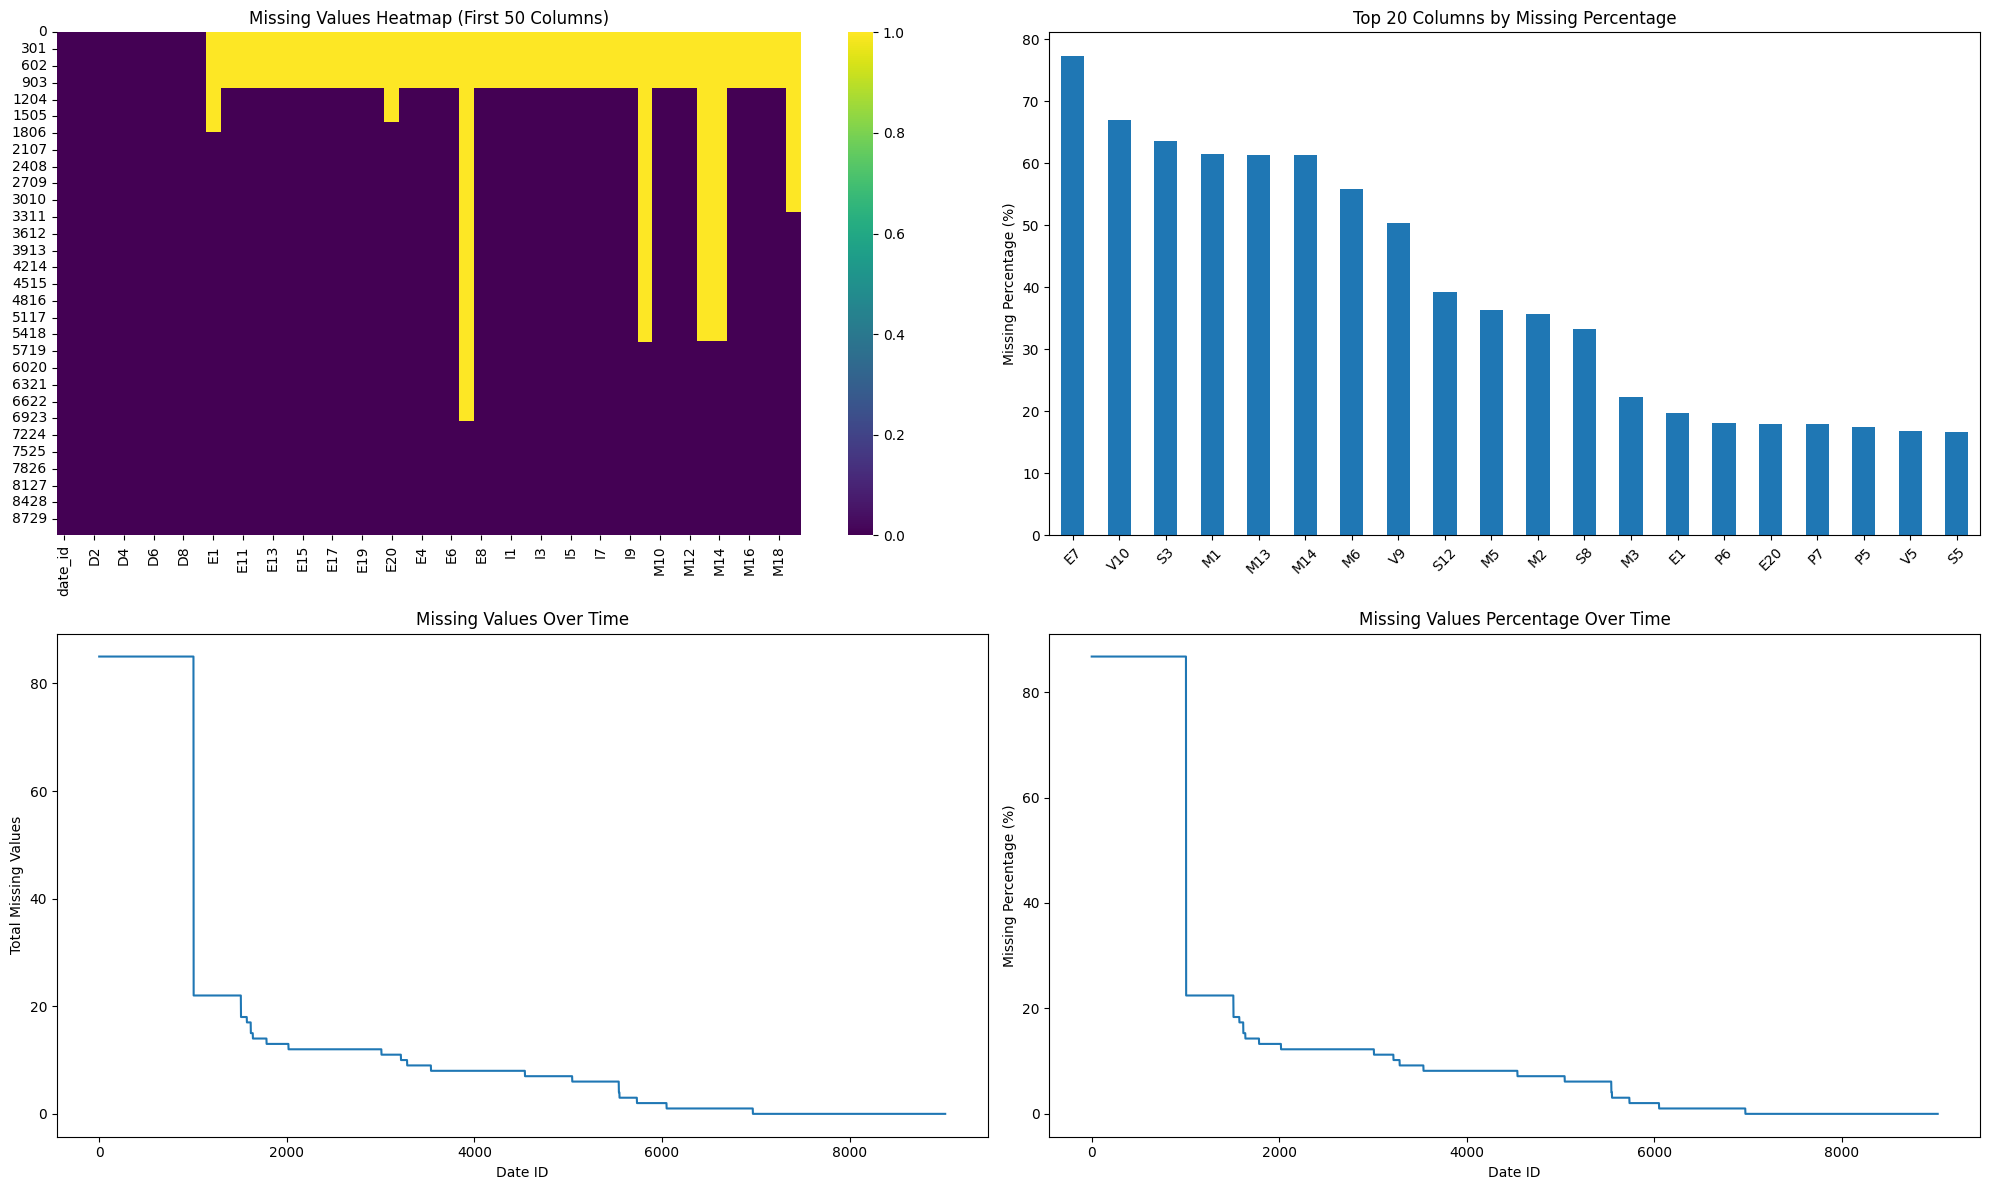

In [7]:
missing_analysis = analyze_missing_values(train)

# Feature Categorization

In [8]:
def categorize_features(df):
    feature_categories = {}
    categories = {
        'Market_Dynamics': 'M',
        'Macro_Economic': 'E',
        'Interest_Rate': 'I',
        'Price_Valuation': 'P',
        'Volatility': 'V',
        'Sentiment': 'S',
        'Momentum': 'MOM',
        'Dummy_Binary': 'D'
    }
    for category, prefix in categories.items():
        if prefix == 'MOM':
            feature_categories[category] = [col for col in df.columns if col.startswith(prefix)]
        else:
            feature_categories[category] = [col for col in df.columns if col.startswith(prefix) and not col.startswith('MOM')]
    special_cols = ['date_id','forward_returns','risk_free_rate', 'market_forward_excess_returns']
    feature_categories['Special'] = [col for col in special_cols if col in df.columns]
    total_features = 0 
    for category, features in feature_categories.items():
        print(f"📊 {category}: {len(features)} features")
        total_features += len(features)
    
    print(f"\nTotal categorized features: {total_features}")
    print(f"Total columns in dataset: {df.shape[1]}")
    
    return feature_categories


In [9]:
feature_categories = categorize_features(train)

📊 Market_Dynamics: 18 features
📊 Macro_Economic: 20 features
📊 Interest_Rate: 9 features
📊 Price_Valuation: 13 features
📊 Volatility: 13 features
📊 Sentiment: 12 features
📊 Momentum: 0 features
📊 Dummy_Binary: 9 features
📊 Special: 4 features

Total categorized features: 98
Total columns in dataset: 98


# Target Variable Analysis

In [10]:
def analyze_target_variable(df):
    target_cols = ['market_forward_excess_returns','forward_returns','risk_free_rate']
    target_cols = [col for col in target_cols if col in df.columns]

    fix, axes = plt.subplots(3, len(target_cols), figsize=(20,15))
    if len(target_cols)==1:
        axes=axes.reshape(-1,1)
    
    for i, col in enumerate(target_cols):
        if col in df.columns:
            data = df[col].dropna()

            print(f"\n📊 {col.upper()} Statistics:")
            print(f"Count: {len(data):,}")
            print(f"Mean: {data.mean():.6f}")
            print(f"Std: {data.std():.6f}")
            print(f"Min: {data.min():.6f}")
            print(f"25%: {data.quantile(0.25):.6f}")
            print(f"50%: {data.median():.6f}")
            print(f"75%: {data.quantile(0.75):.6f}")
            print(f"Max: {data.max():.6f}")
            print(f"Skewness: {data.skew():.6f}")
            print(f"Kurtosis: {data.kurtosis():.6f}")

            axes[0, i].hist(data, bins=50, alpha=0.7, density=True)
            axes[0,i].axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.4f}')
            axes[0,i].axvline(data.median(), color='green', linestyle='--', label=f'Median: {data.median():.4f}')
            axes[0, i].set_title(f'{col} Distribution')
            axes[0, i].legend()

            if 'date_id' in df.columns:
                axes[1, i].plot(df['date_id'], df[col], alpha=0.7)
                axes[1, i].set_title(f'{col} Over Time')
                axes[1, i].set_xlabel('Date ID')

            stats.probplot(data, dist='norm', plot=axes[2,i])
            axes[2,i].set_title(f'{col} Q-Q Plot')

            jb_stat, jb_pvalue = jarque_bera(data)
            print(f"Jarque-Bera test p-value: {jb_pvalue:.6f} ({'Normal' if jb_pvalue > 0.05 else 'Not Normal'})")
    
    plt.tight_layout
    plt.show()
    return target_cols


📊 MARKET_FORWARD_EXCESS_RETURNS Statistics:
Count: 9,021
Mean: 0.000053
Std: 0.010558
Min: -0.040582
25%: -0.004747
50%: 0.000255
75%: 0.005479
Max: 0.040551
Skewness: -0.180045
Kurtosis: 2.245426
Jarque-Bera test p-value: 0.000000 (Not Normal)

📊 FORWARD_RETURNS Statistics:
Count: 9,021
Mean: 0.000471
Std: 0.010541
Min: -0.039754
25%: -0.004319
50%: 0.000659
75%: 0.005896
Max: 0.040661
Skewness: -0.178182
Kurtosis: 2.199769
Jarque-Bera test p-value: 0.000000 (Not Normal)

📊 RISK_FREE_RATE Statistics:
Count: 9,021
Mean: 0.000107
Std: 0.000088
Min: -0.000004
25%: 0.000008
50%: 0.000097
75%: 0.000193
Max: 0.000317
Skewness: 0.213427
Kurtosis: -1.265853
Jarque-Bera test p-value: 0.000000 (Not Normal)


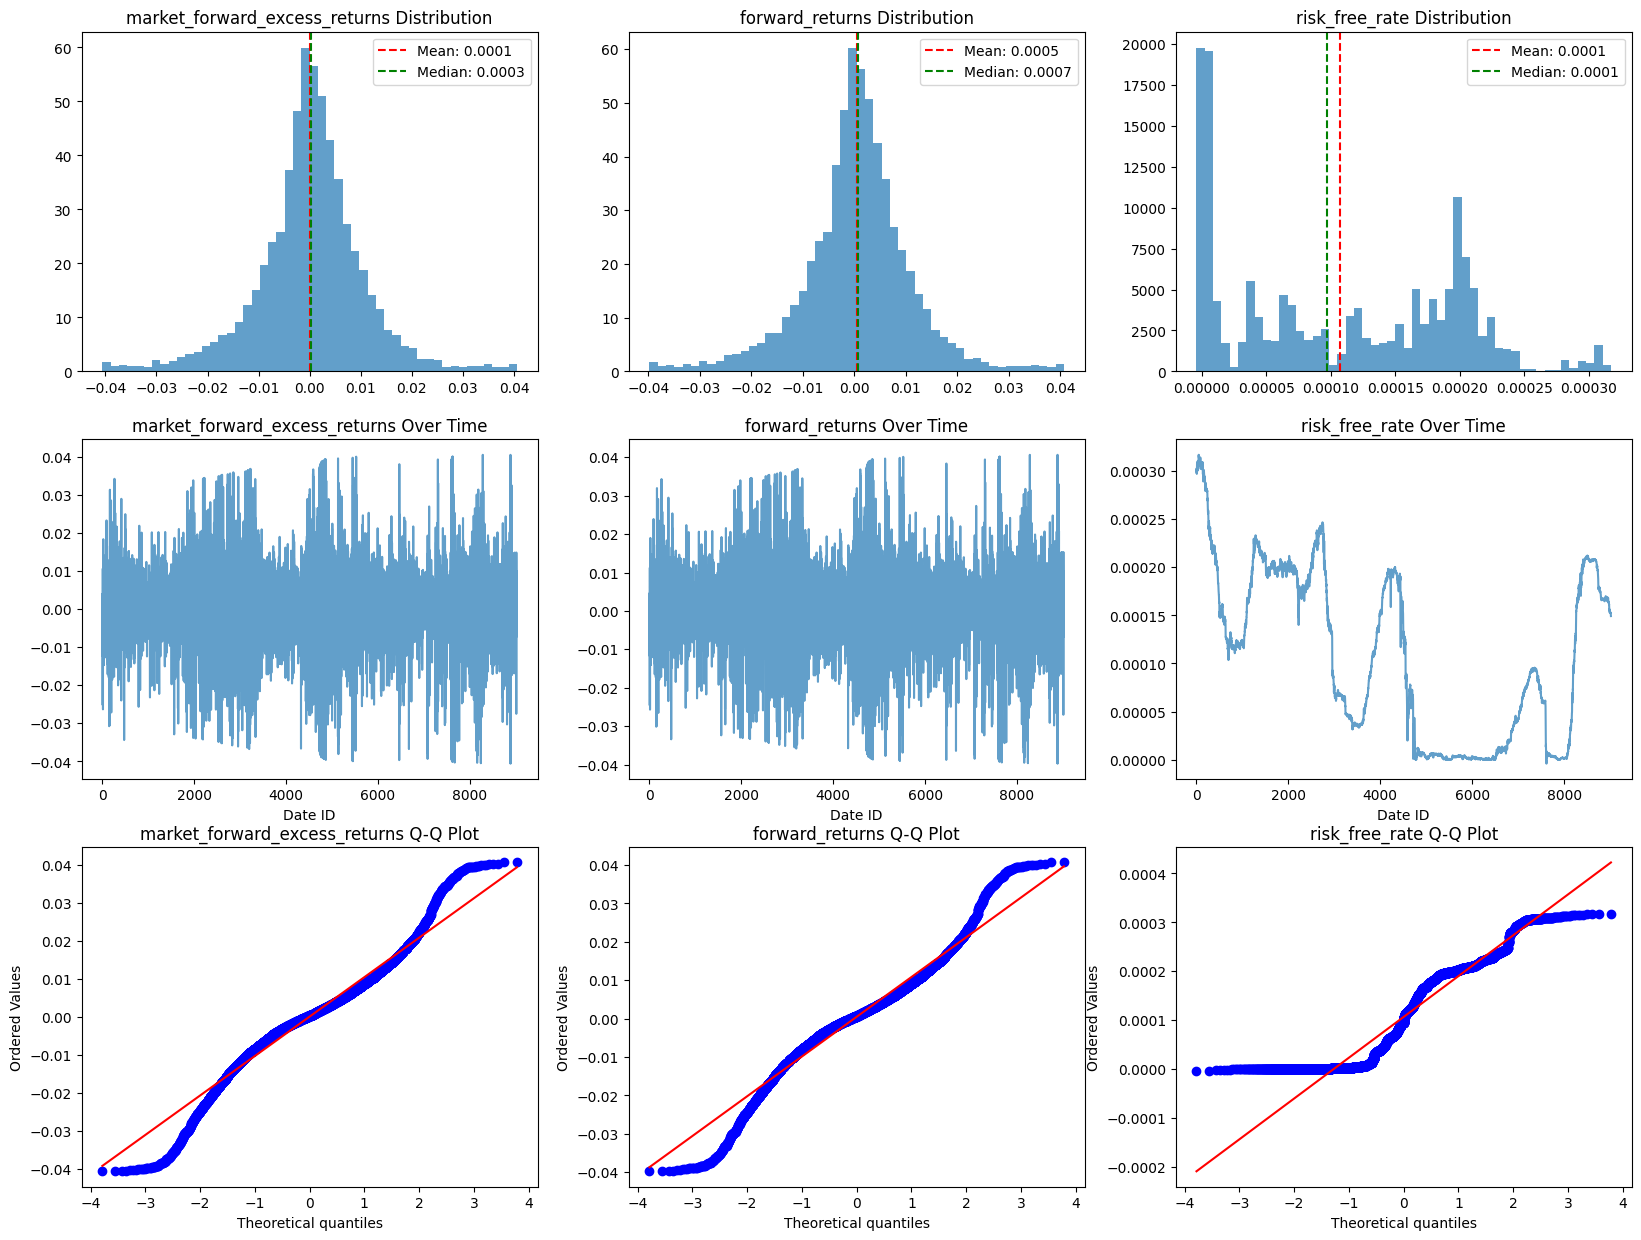

In [11]:
target_analysis = analyze_target_variable(train)

# Feature Distribution Analysis

In [12]:
def analyze_feature_distributions(df, feature_categories, sample_size=10):
    for category, features in feature_categories.items():
        if category=='Special' or len(features)==0:
            continue
        print(f"\n Analyzing {category} features ({len(features)} total)")
        sample_features = features[:min(sample_size, len(features))]
        if len(sample_features) > 0:
            n_cols = min(4, len(sample_features))
            n_rows = (len(sample_features) + n_cols - 1) // n_cols

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
            if n_rows == 1:
                axes = axes.reshape(1, -1)
            elif n_cols == 1:
                axes = axes.reshape(-1, 1)
            for idx, feature in enumerate(sample_features):
                row = idx // n_cols
                col = idx % n_cols
                data = df[feature].dropna()
                if len(data) > 0:
                    axes[row, col].hist(data, bins=30, alpha=0.7)
                    axes[row, col].set_title(f'{feature}')
                    axes[row, col].axvline(data.mean(), color='red', linestyle='--', alpha=0.8)
                    stats_text = f'Mean: {data.mean():.3f}\nStd: {data.std():.3f}\nSkew: {data.skew():.2f}'
                    axes[row, col].text(0.02, 0.98, stats_text, transform=axes[row, col].transAxes,verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.8))
            for idx in range(len(sample_features), n_rows * n_cols):
                row = idx // n_cols
                col = idx % n_cols
                axes[row, col].set_visible(False)
            plt.suptitle(f'{category} Features Distribution (Sample of {len(sample_features)})', fontsize=16)
            plt.tight_layout()
            plt.show()



 Analyzing Market_Dynamics features (18 total)


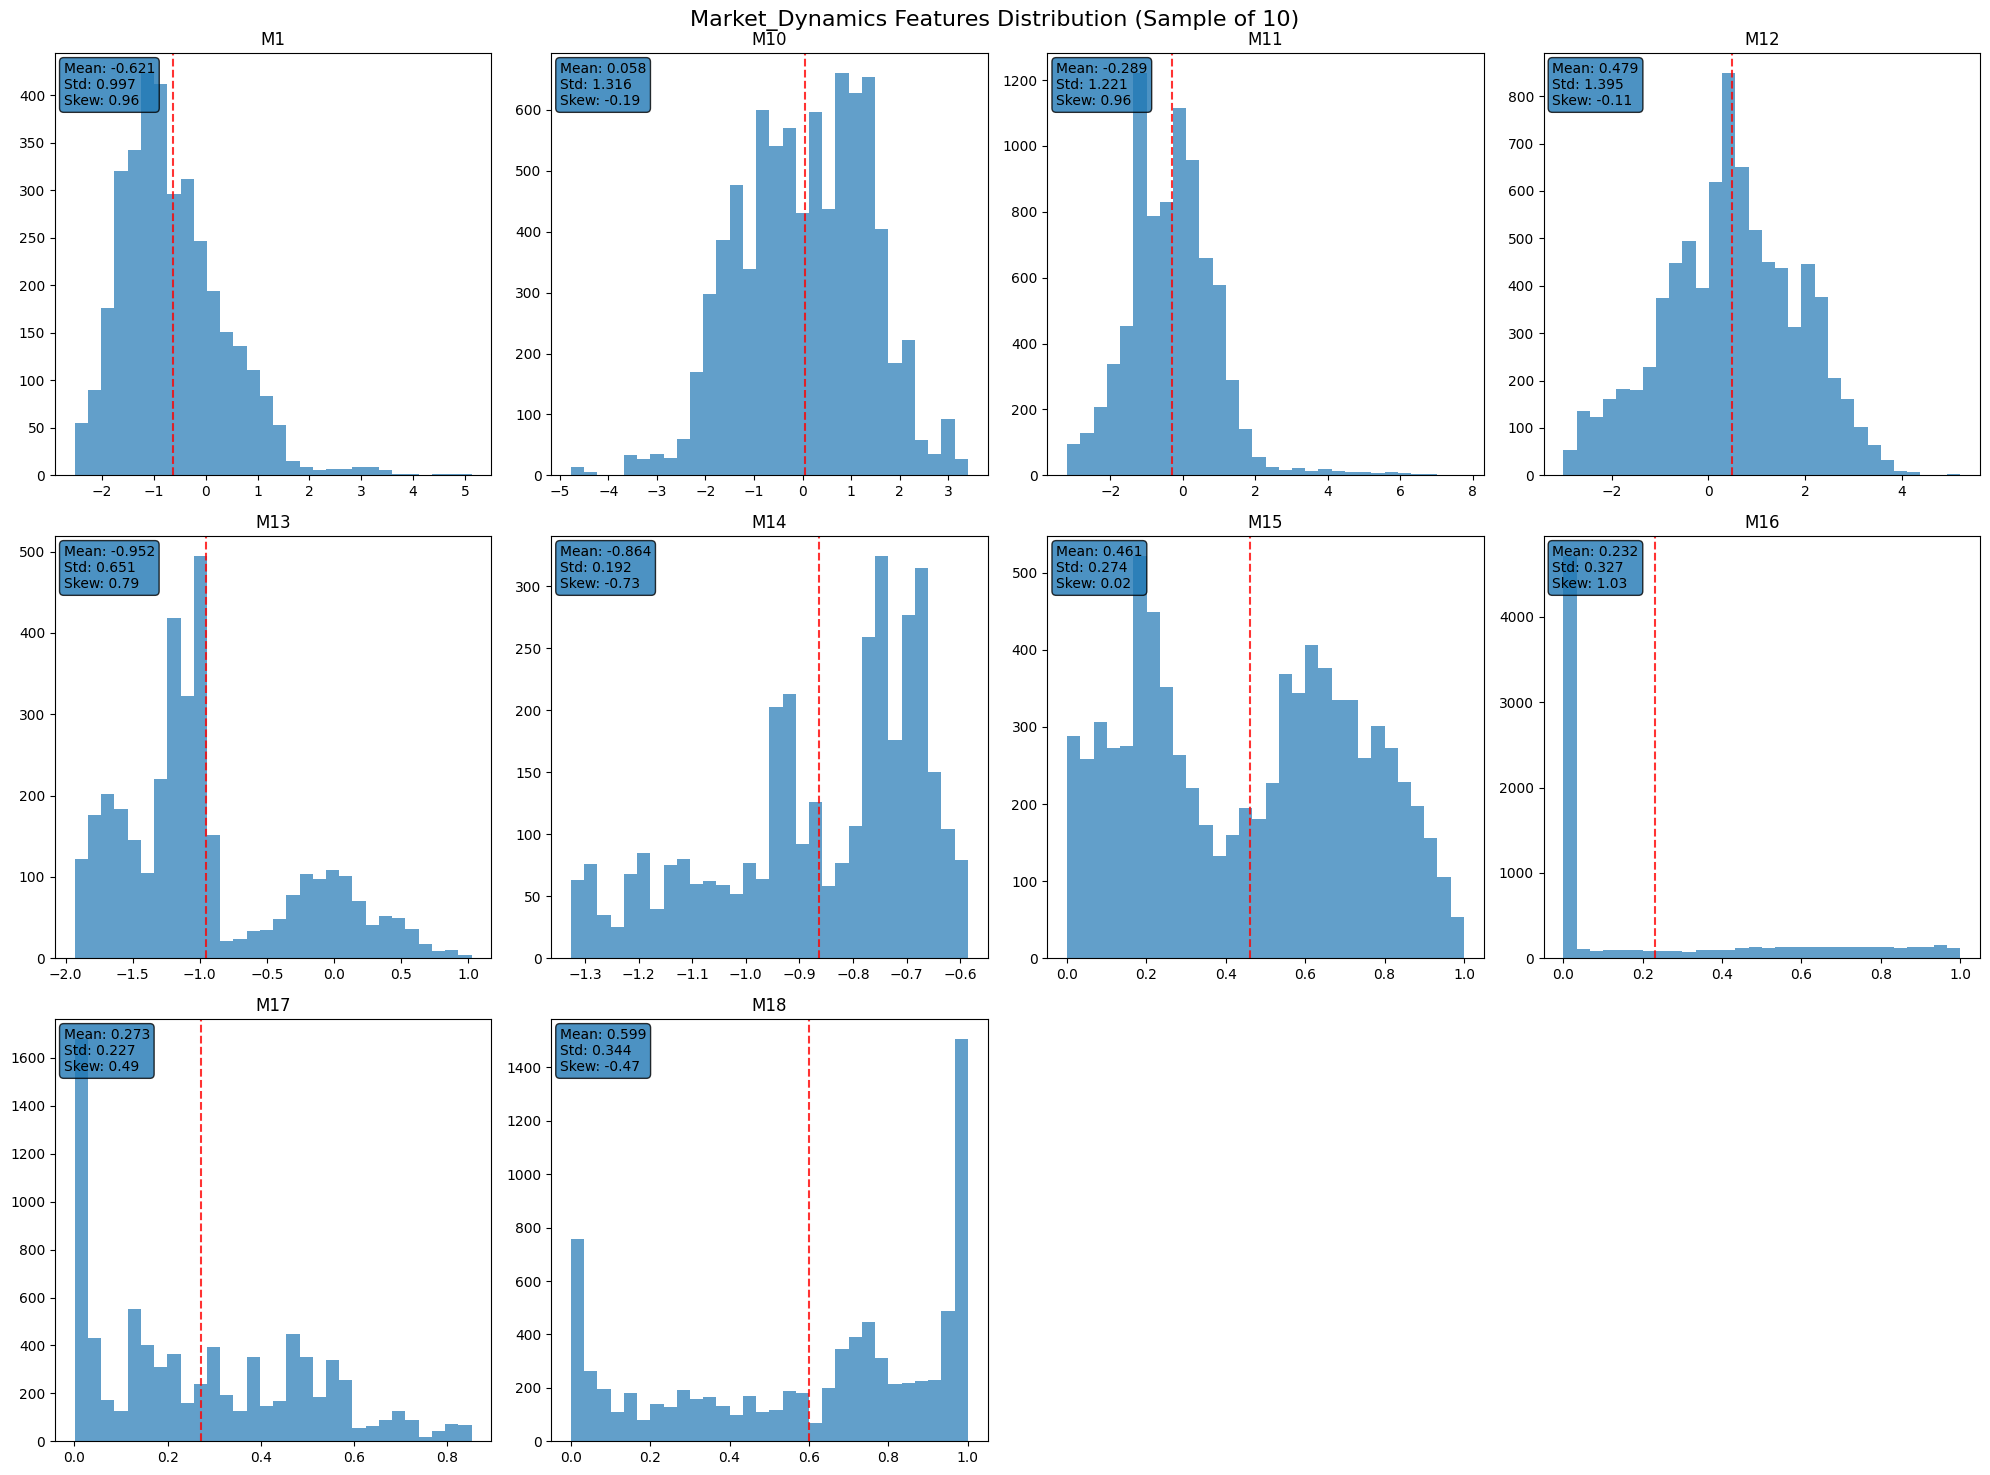


 Analyzing Macro_Economic features (20 total)


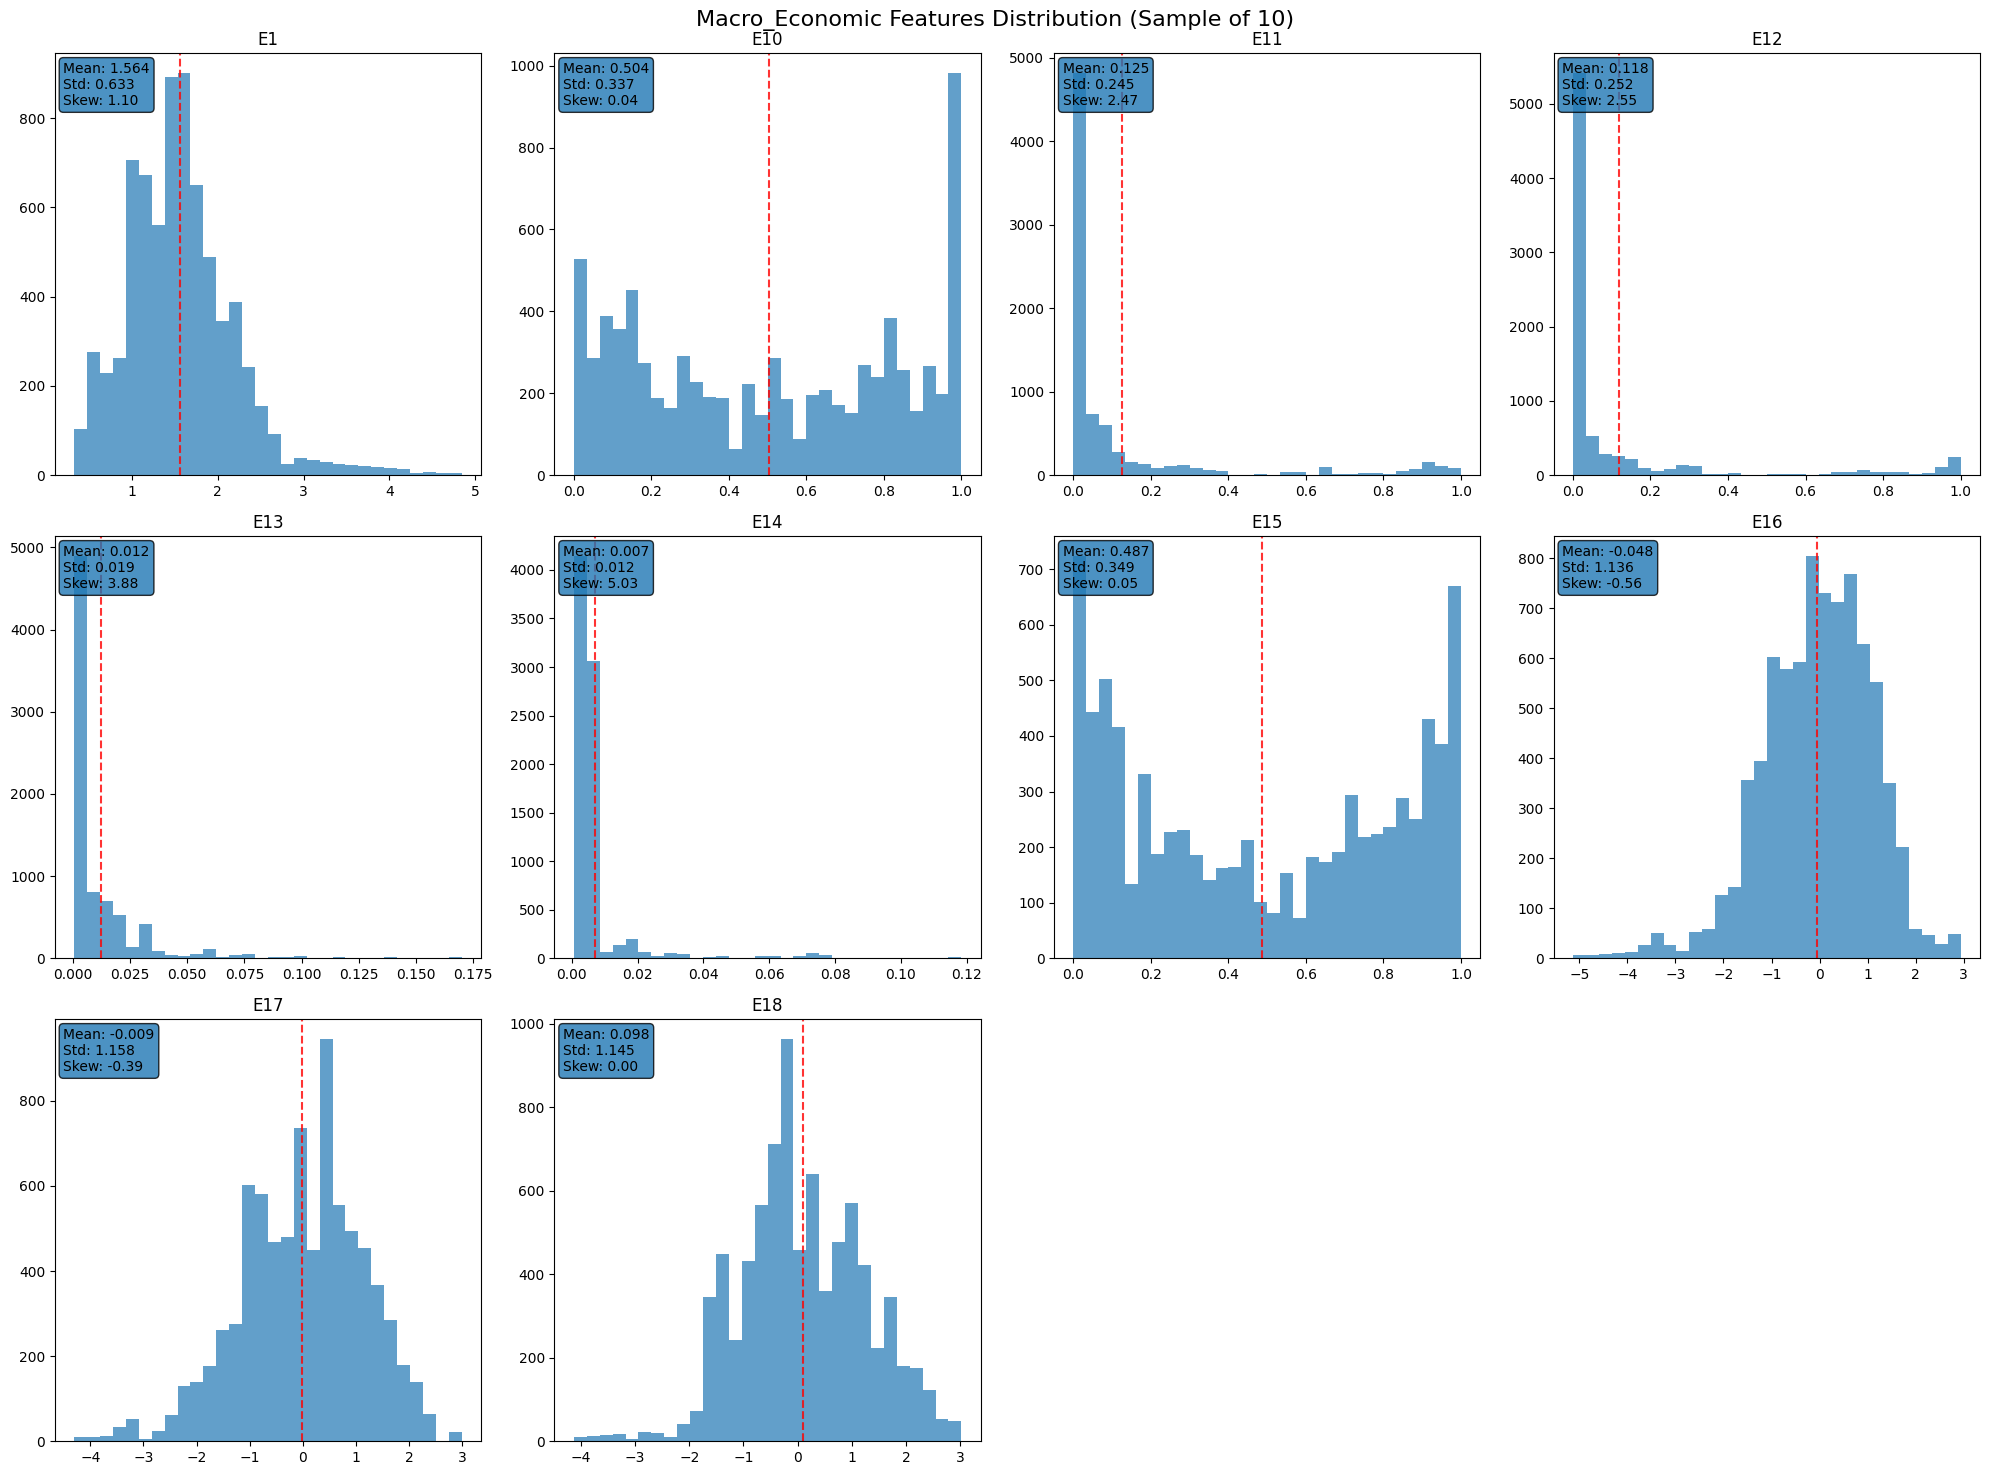


 Analyzing Interest_Rate features (9 total)


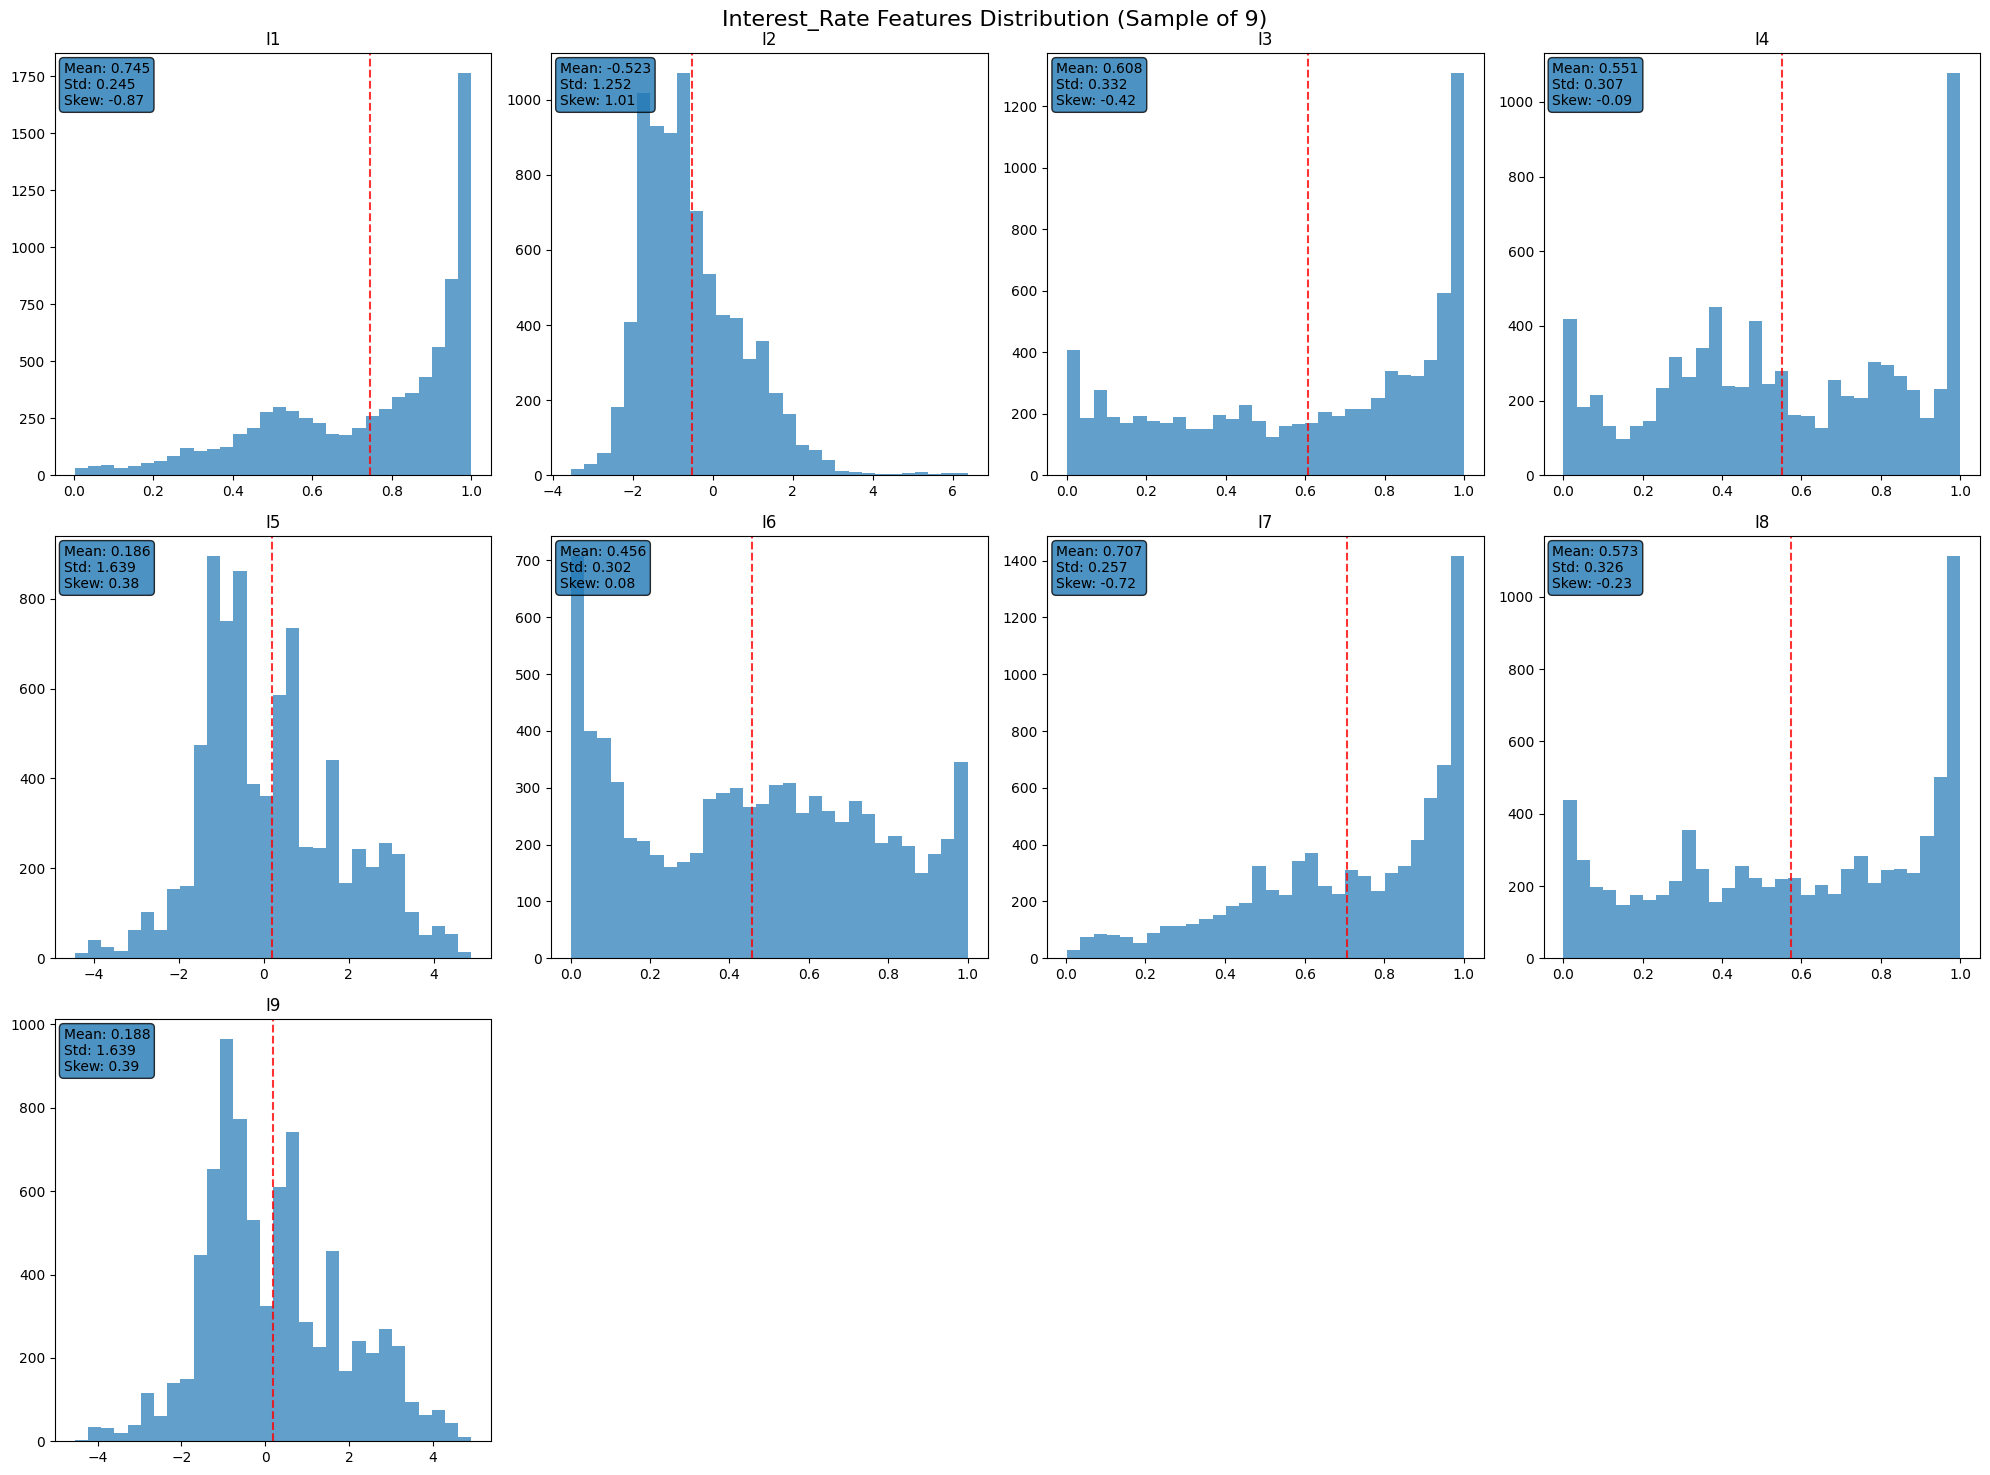


 Analyzing Price_Valuation features (13 total)


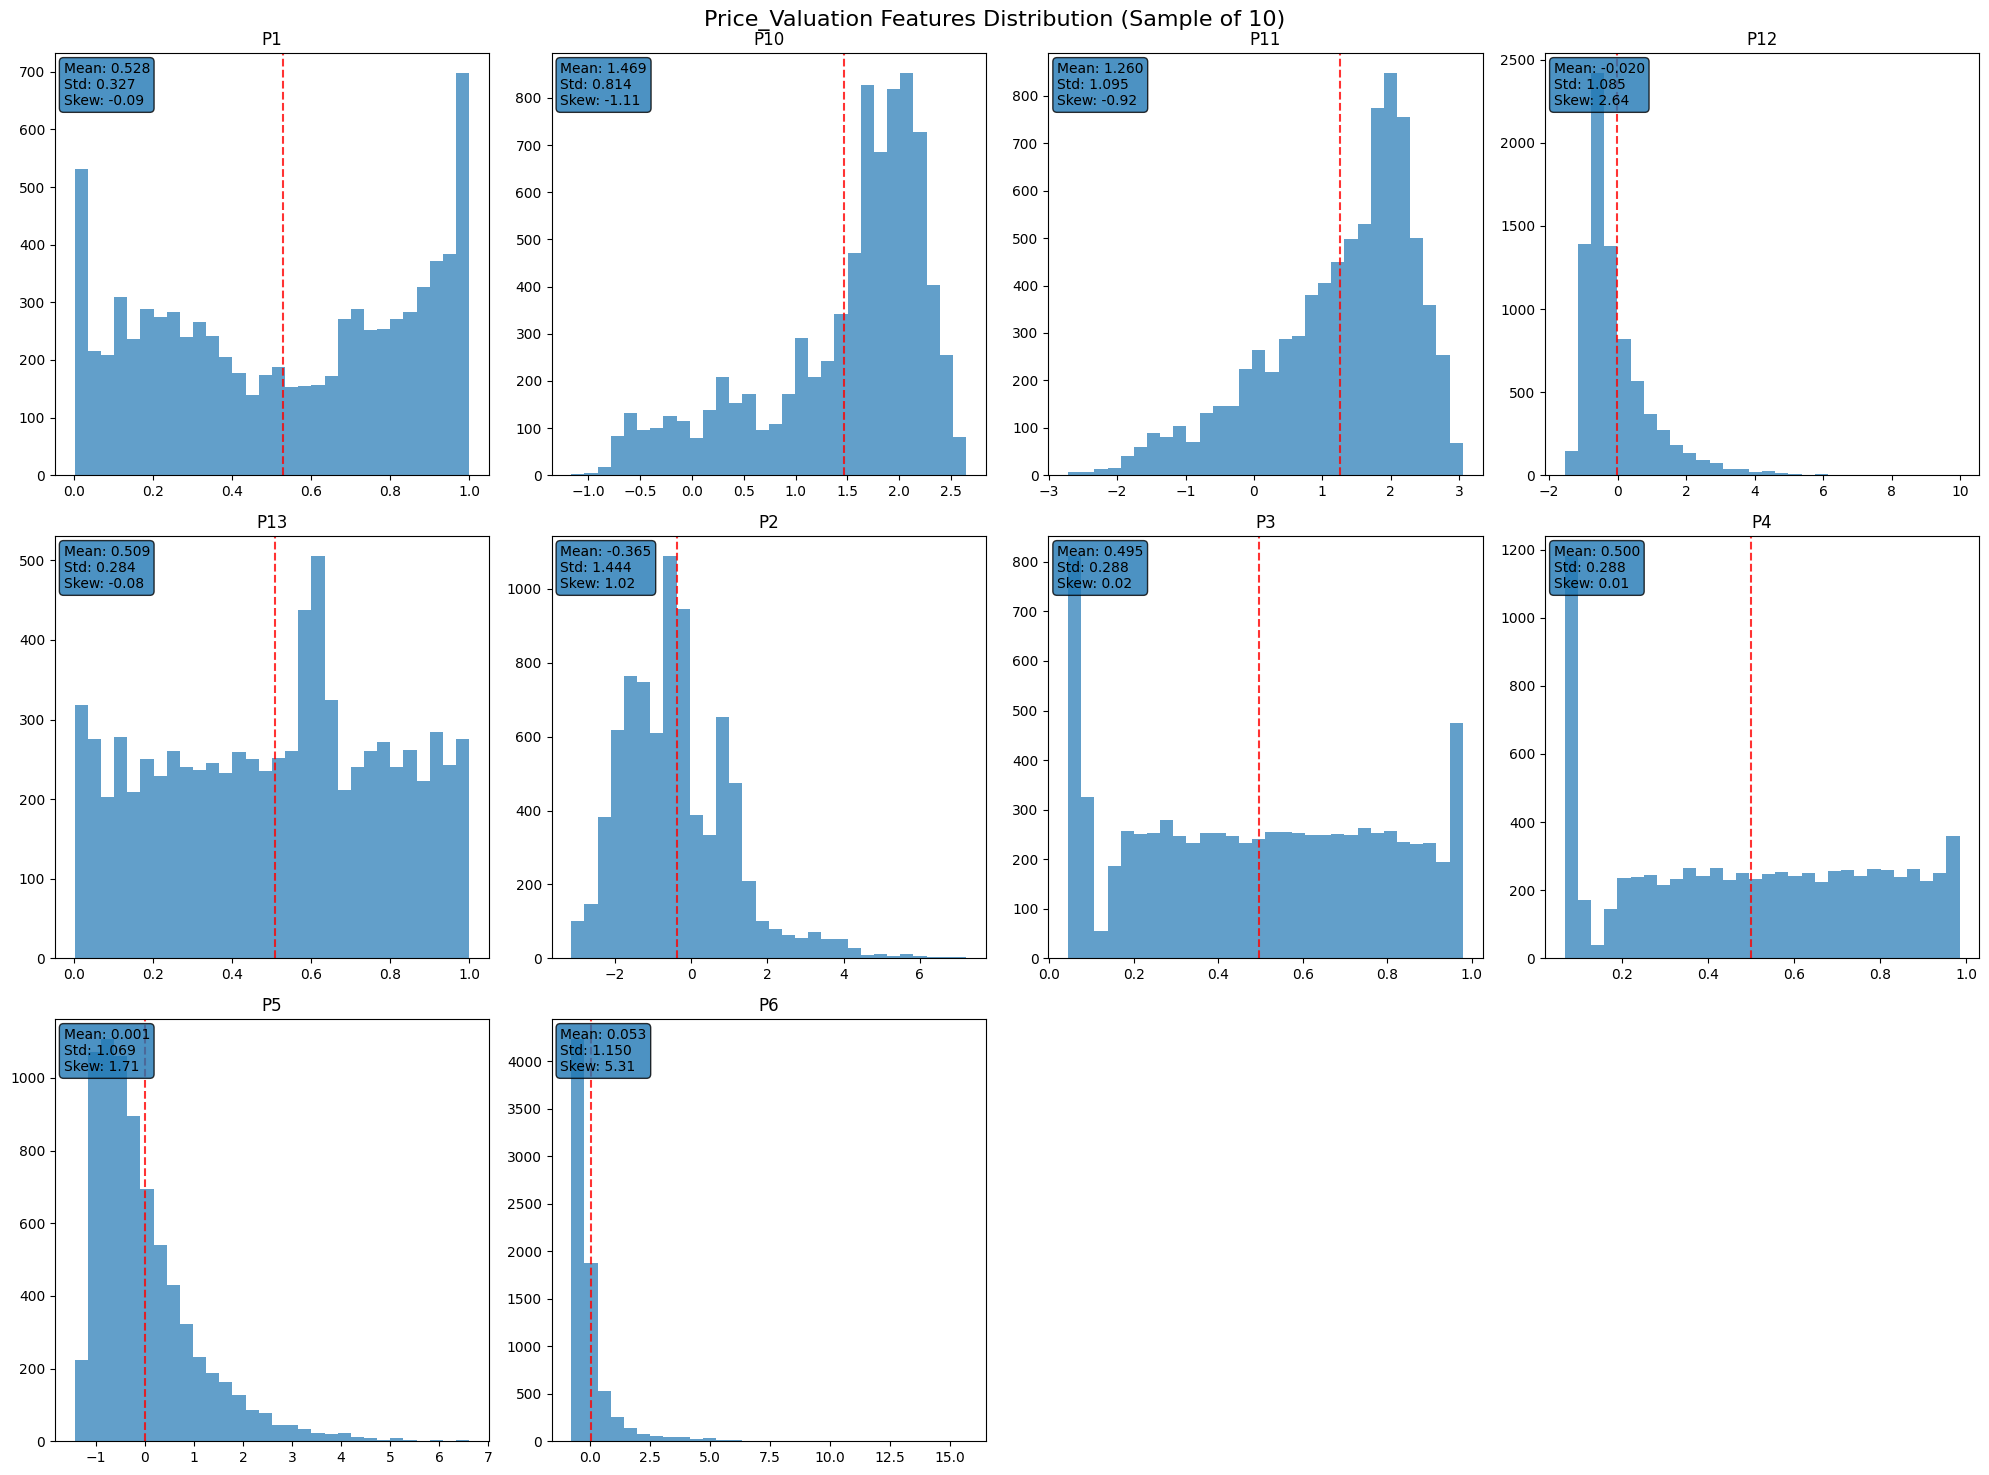


 Analyzing Volatility features (13 total)


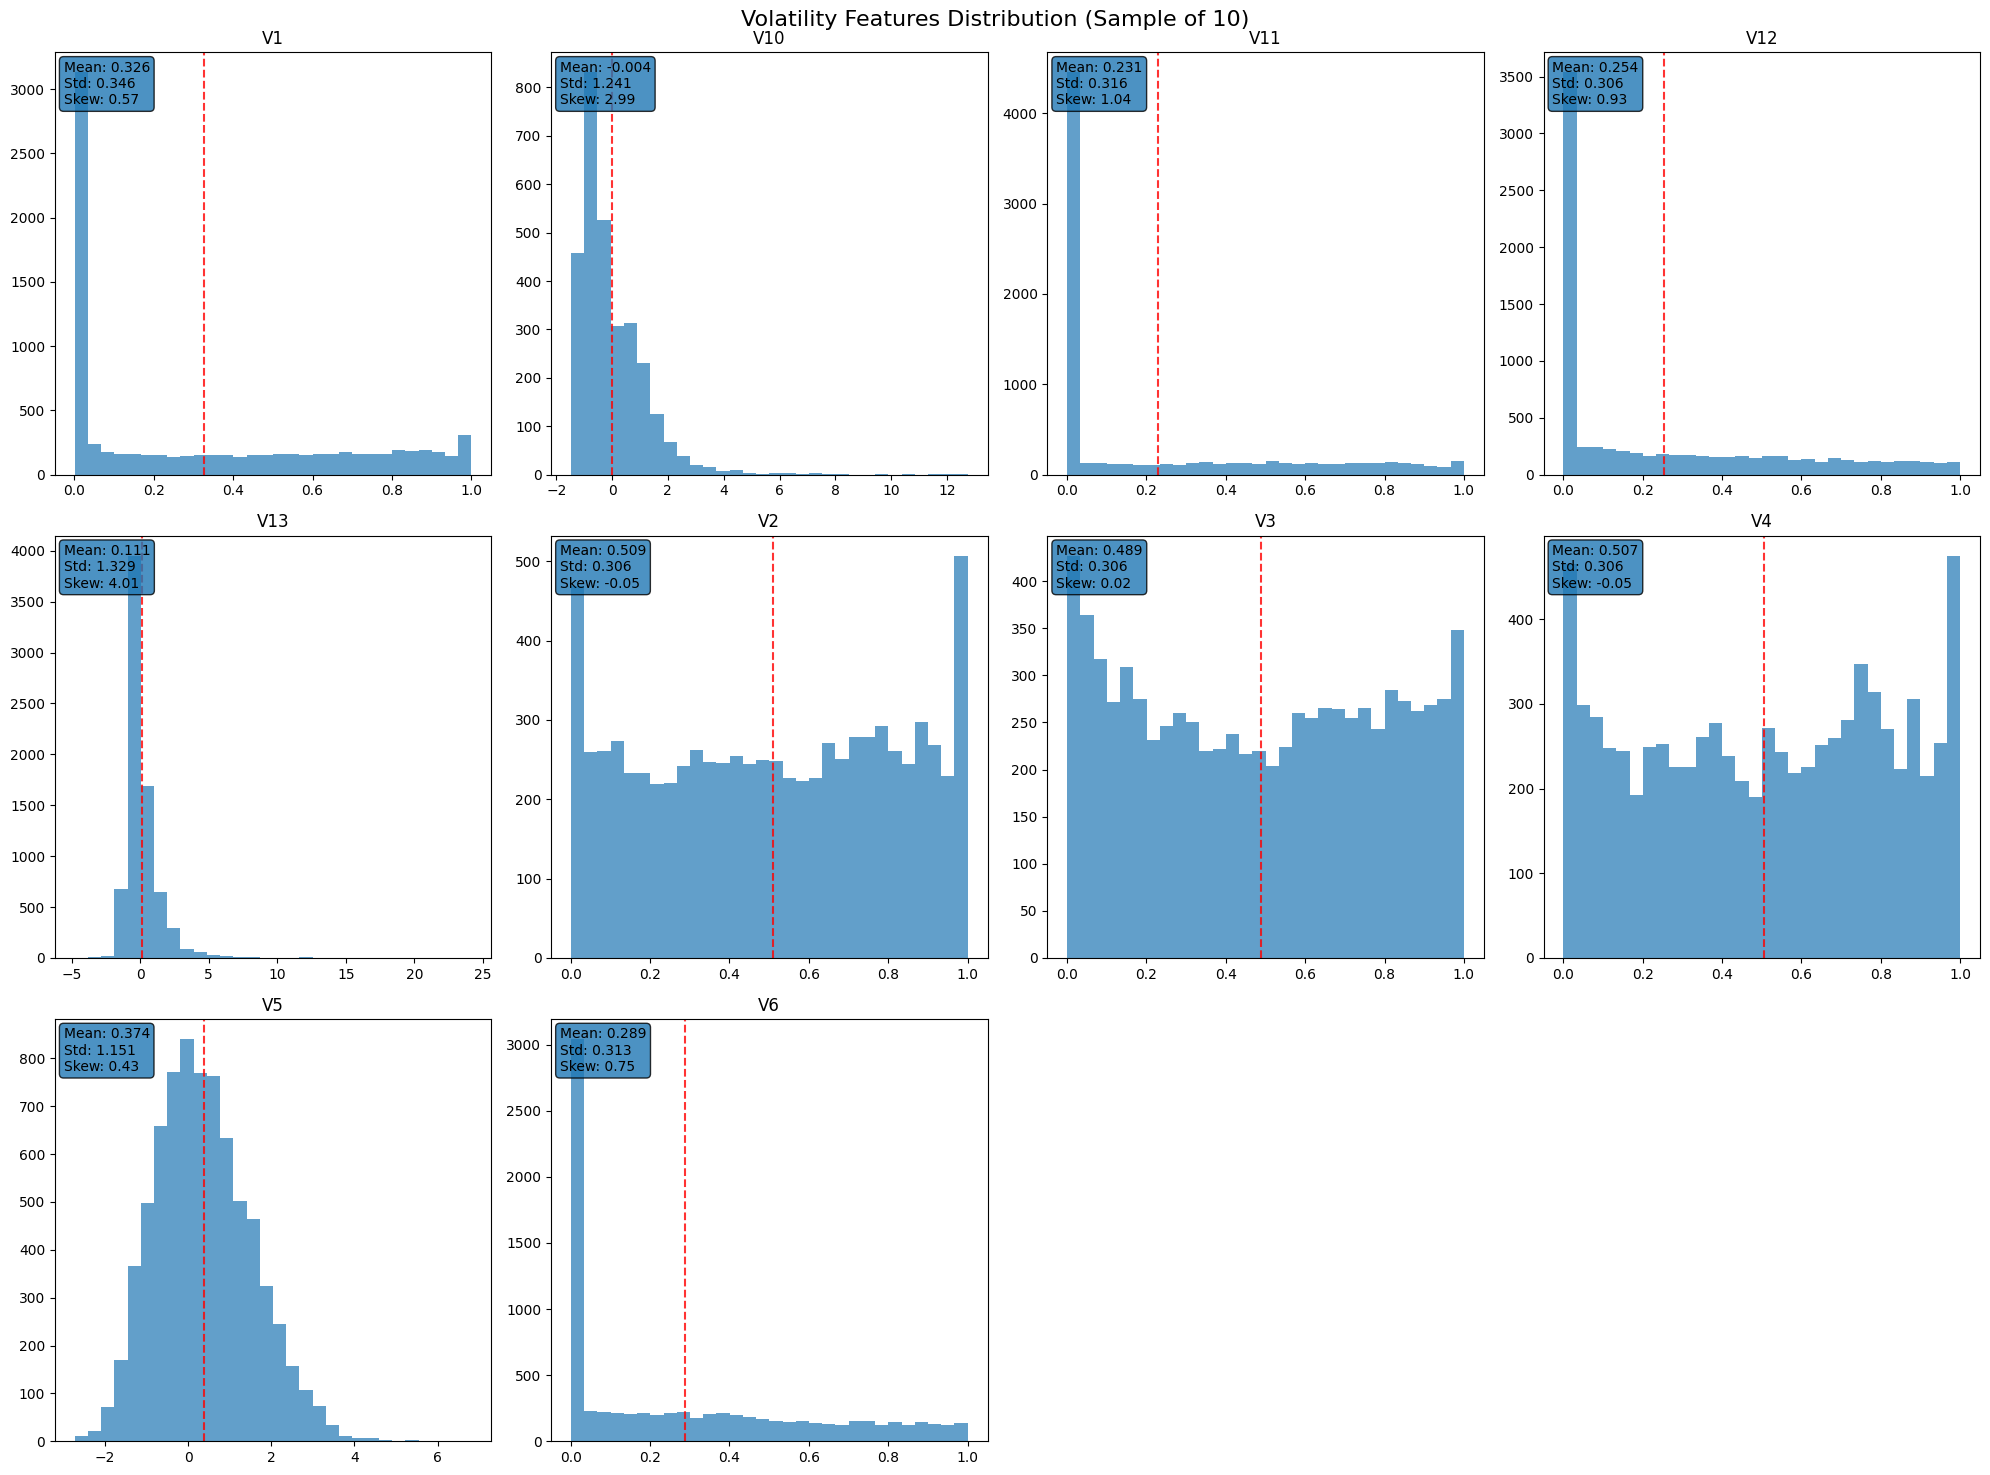


 Analyzing Sentiment features (12 total)


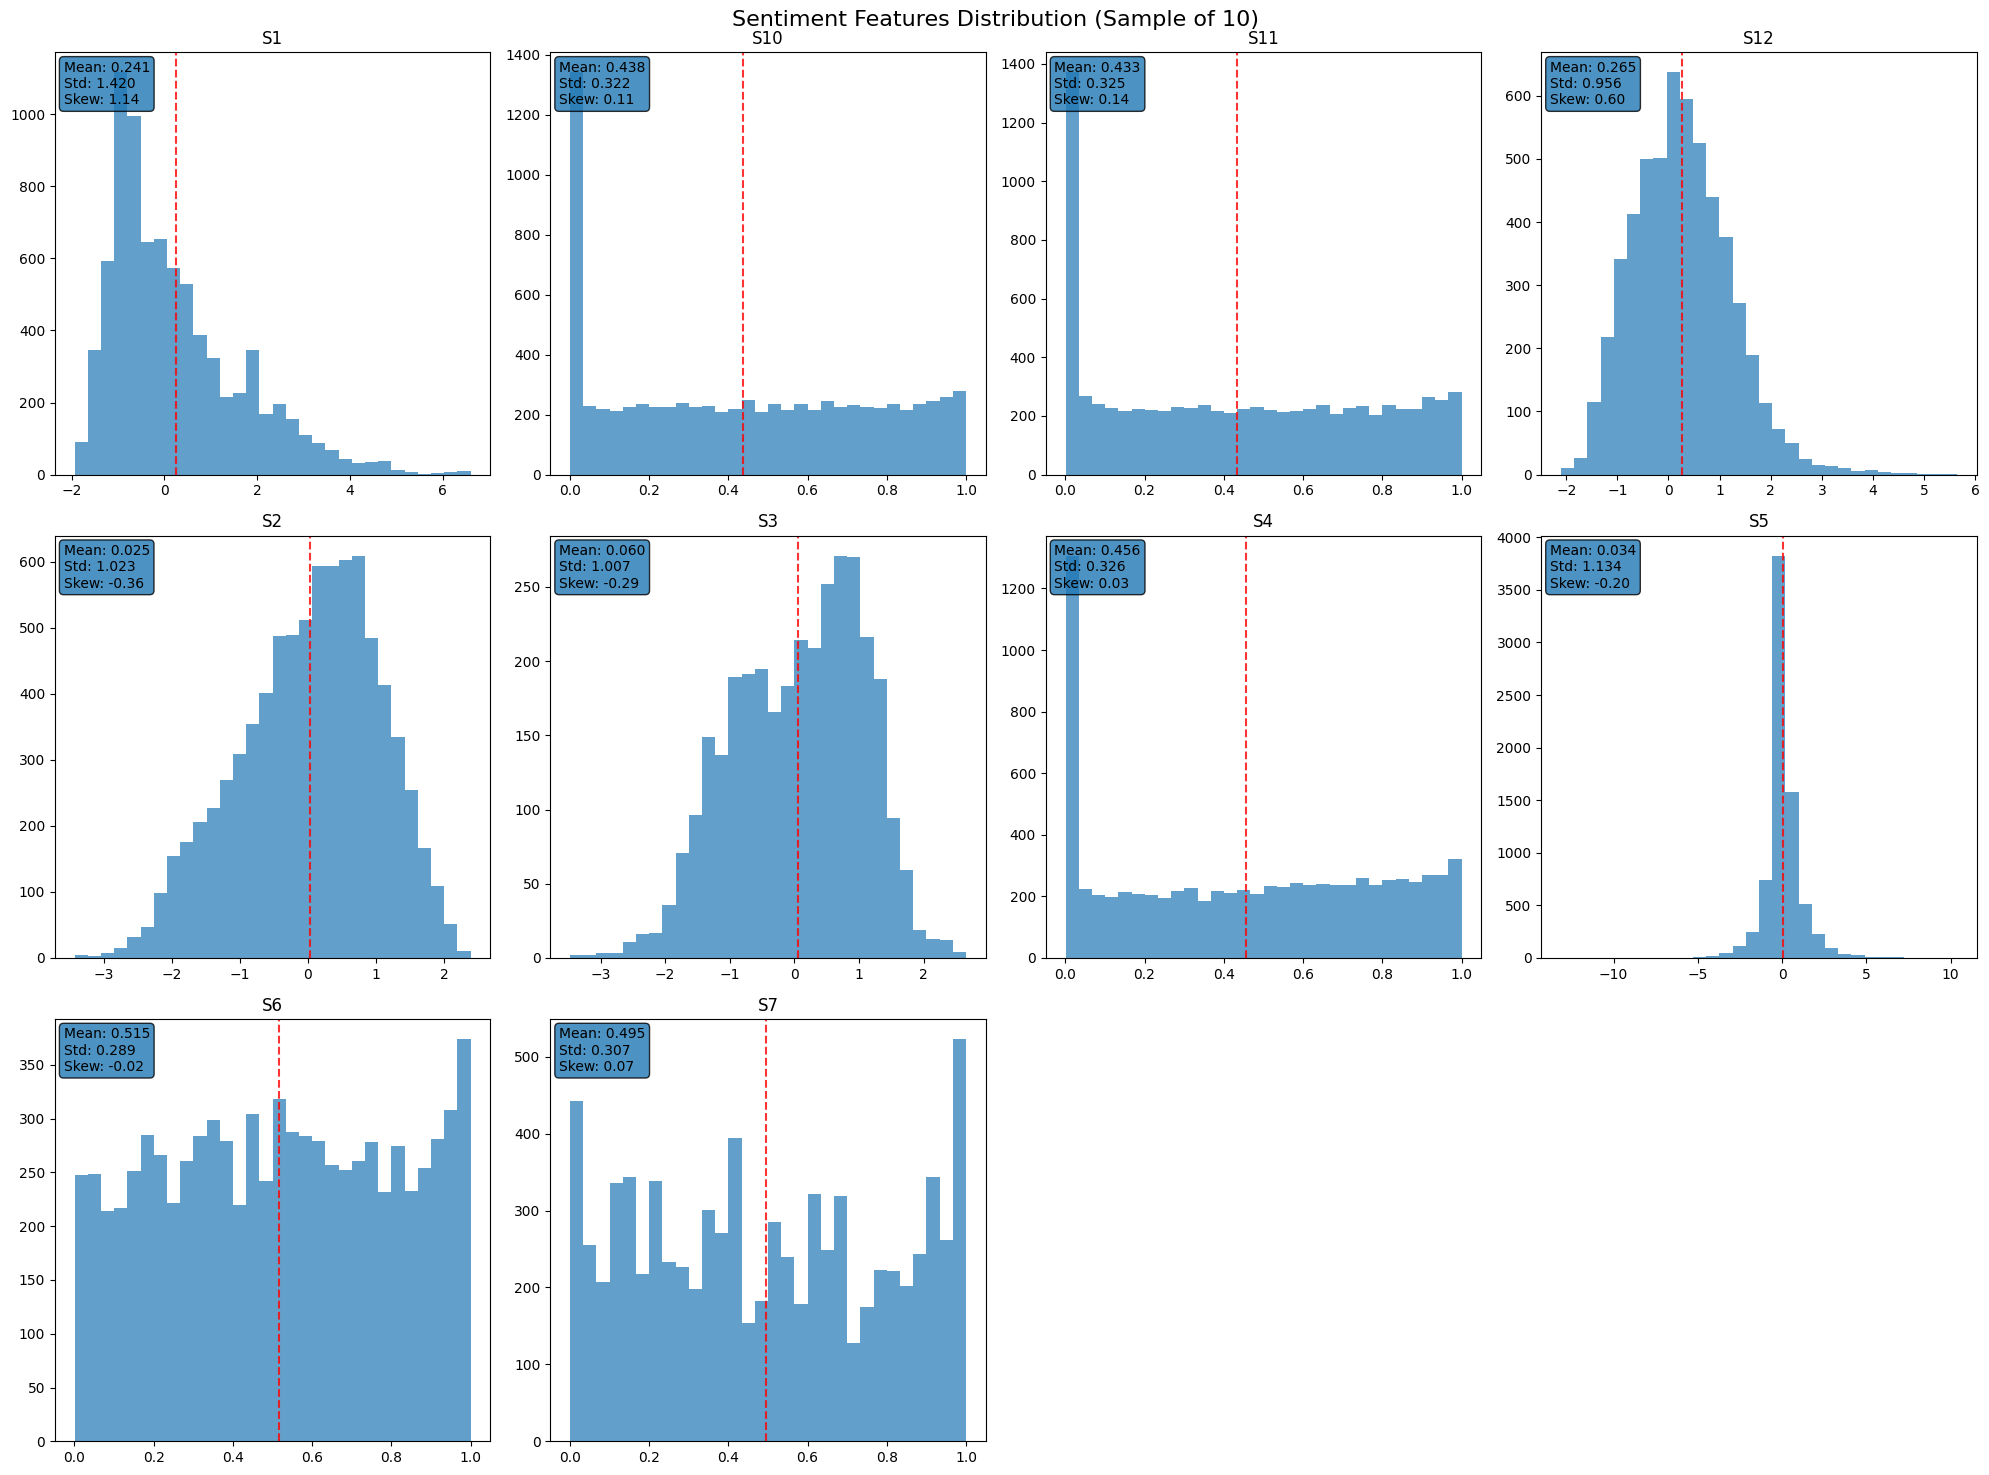


 Analyzing Dummy_Binary features (9 total)


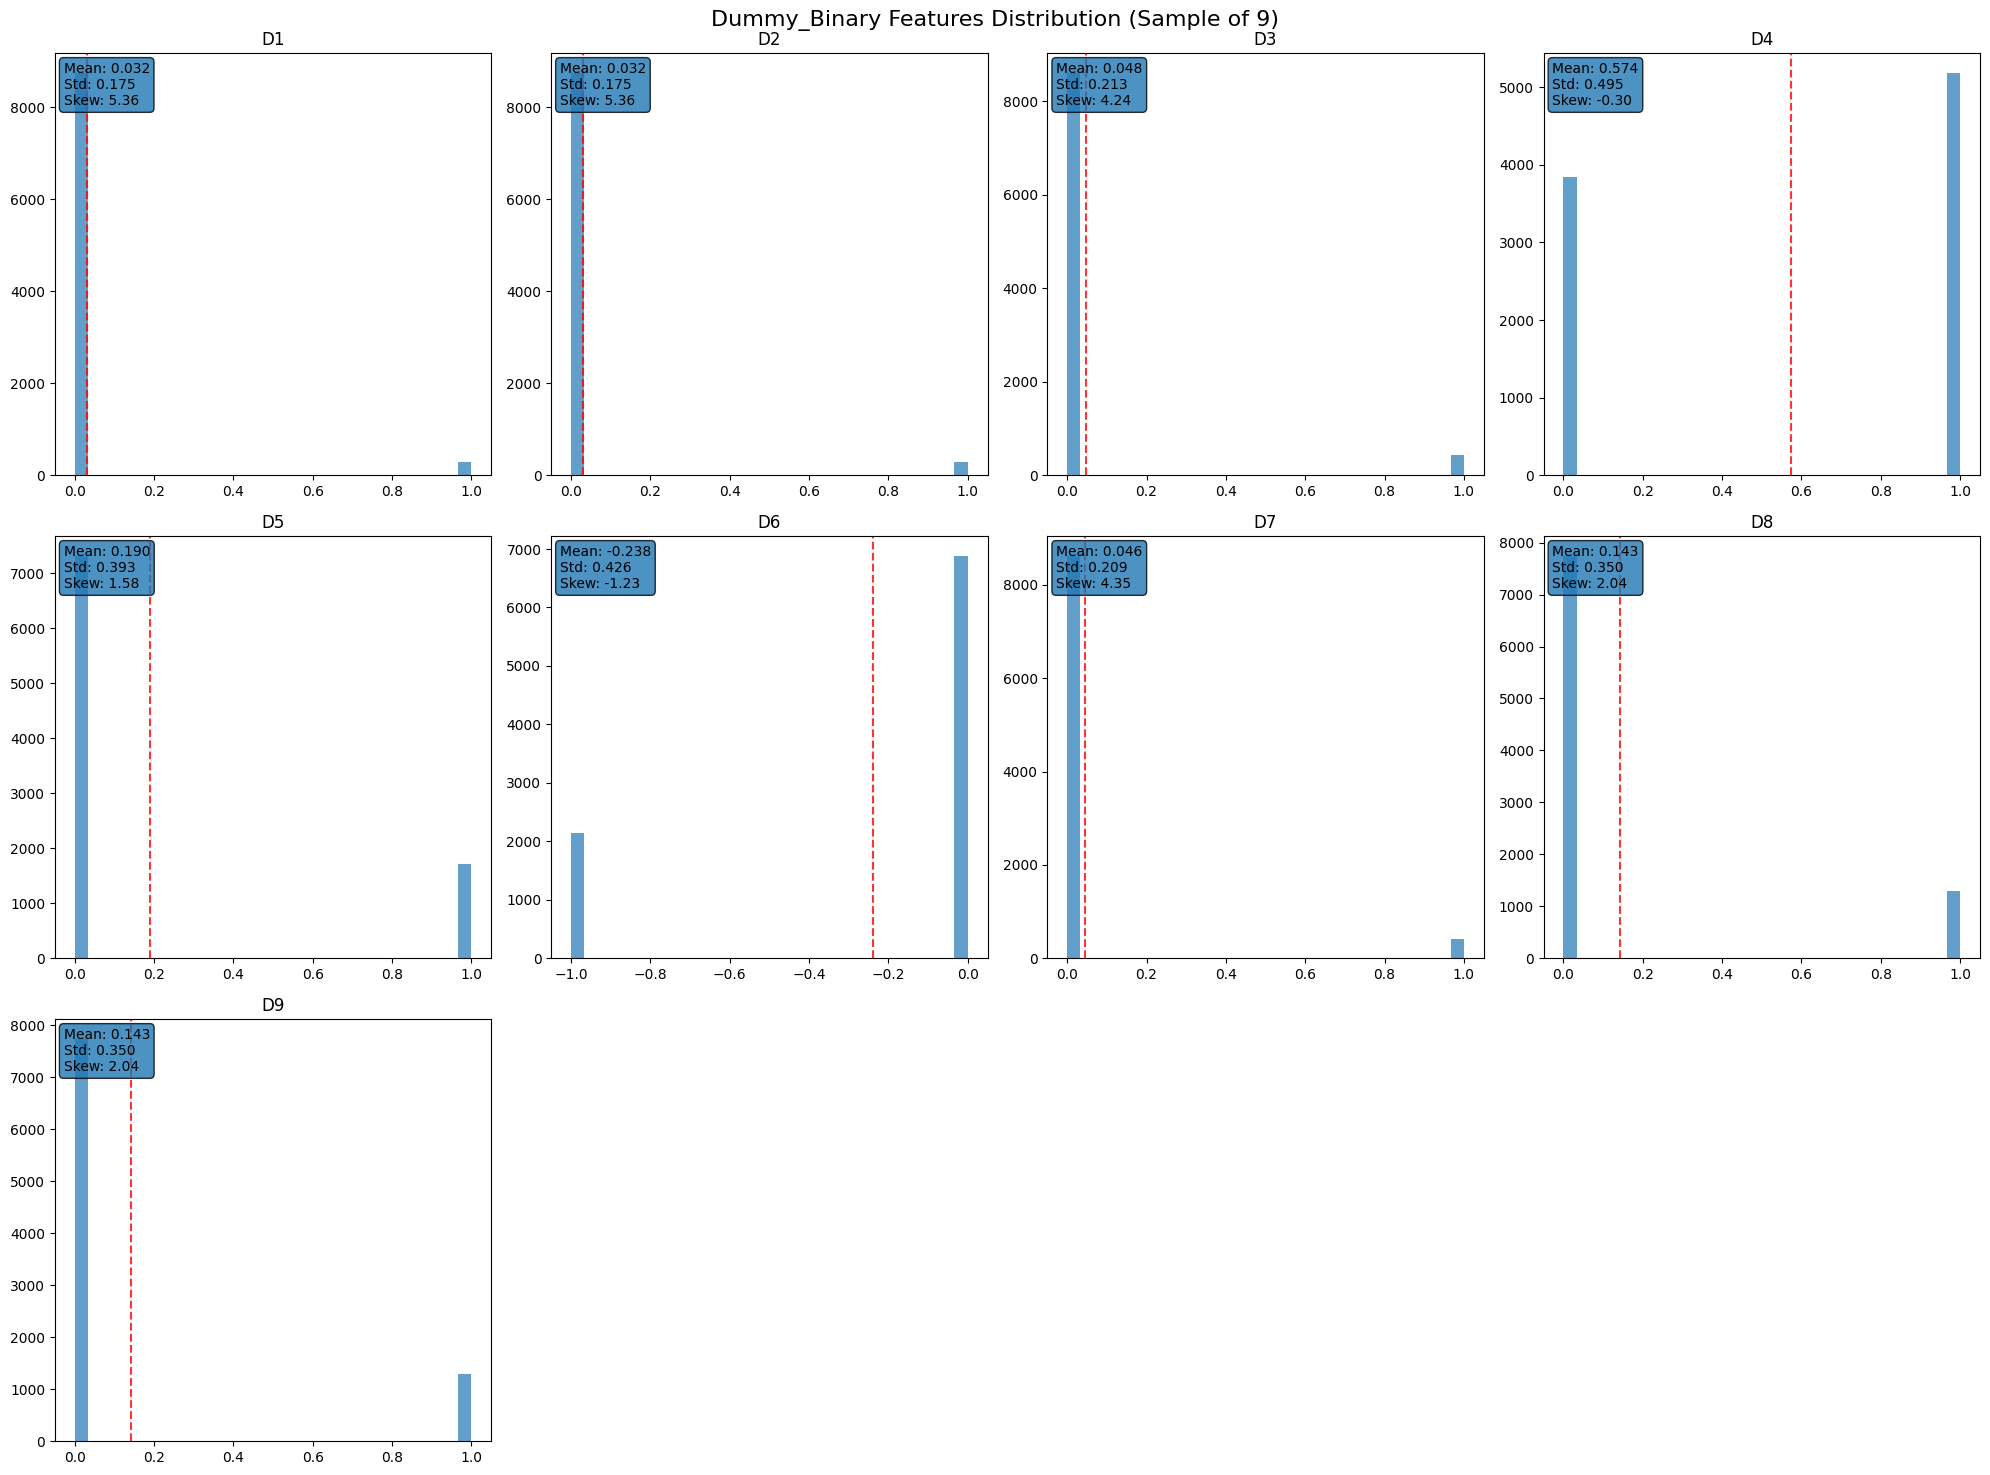

In [13]:
analyze_feature_distributions(train, feature_categories)

# Correlation Analysis

In [14]:
def analyze_correlations(df, feature_categories):
    if 'forward_returns' in df.columns:
        target_corr = df.corr()['forward_returns'].sort_values(ascending=False)
        target_corr = target_corr.drop('forward_returns')

        print("🎯 TOP 20 FEATURES CORRELATED WITH FORWARD RETURNS:")
        print(target_corr.head(20))
        
        print("\n🎯 BOTTOM 20 FEATURES CORRELATED WITH FORWARD RETURNS:")
        print(target_corr.tail(20))
        
        fig, axes = plt.subplots(1,2, figsize=(20,8))
        top_pos = target_corr.head(15)
        top_pos.plot(kind='barh', ax=axes[0],color='green', alpha=0.7)
        axes[0].set_title('Top 15 Positive Correlations with Forward Returns')
        axes[0].set_xlabel('Correlation')

        top_neg = target_corr.tail(15)
        top_neg.plot(kind='barh', ax=axes[1], color='red', alpha=0.7)
        axes[1].set_title('Top 15 Negative Correlations with Forward Returns')
        axes[1].set_xlabel('Correlation')

        plt.tight_layout()
        plt.show()

        #category-wise correlation analysis
        for category, features in feature_categories.items():
            if category == 'Special' or len(features) < 2:
                continue
            print(f"\n🔍 {category} Internal Correlations:")

            category_df  = df[features].dropna()
            if len(category) > 0 and len(features) > 1:
                corr_matrix = category_df.corr()
                
                high_corr_pairs = []
                for i in range(len(corr_matrix.columns)):
                    for j in range(i+1, len(corr_matrix.columns)):
                        corr_val = corr_matrix.iloc[i, j]
                        if abs(corr_val) > 0.8:
                            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))
                
                if high_corr_pairs:
                    print(f"High correlations (|r| > 0.8): {len(high_corr_pairs)} pairs")
                    for pair in high_corr_pairs[:10]:  # Show top 10
                        print(f"  {pair[0]} - {pair[1]}: {pair[2]:.3f}")

                if len(features) <= 20:
                    plt.figure(figsize=(12, 10))
                    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                            square=True, linewidths=0.5, fmt='.2f')
                    plt.title(f'{category} Features Correlation Matrix')
                    plt.tight_layout()
                    plt.show()


🎯 TOP 20 FEATURES CORRELATED WITH FORWARD RETURNS:
market_forward_excess_returns    0.999943
V13                              0.063069
M1                               0.044813
S5                               0.040469
D2                               0.033951
D1                               0.033951
M2                               0.033337
V7                               0.032741
V10                              0.031678
M17                              0.024900
D8                               0.024859
E19                              0.024821
S12                              0.024801
S6                               0.022344
D4                               0.016953
D6                               0.016696
D5                               0.016676
V9                               0.016560
M3                               0.016459
E6                               0.015528
Name: forward_returns, dtype: float64

🎯 BOTTOM 20 FEATURES CORRELATED WITH FORWARD RETURNS:
P11   -0.009281


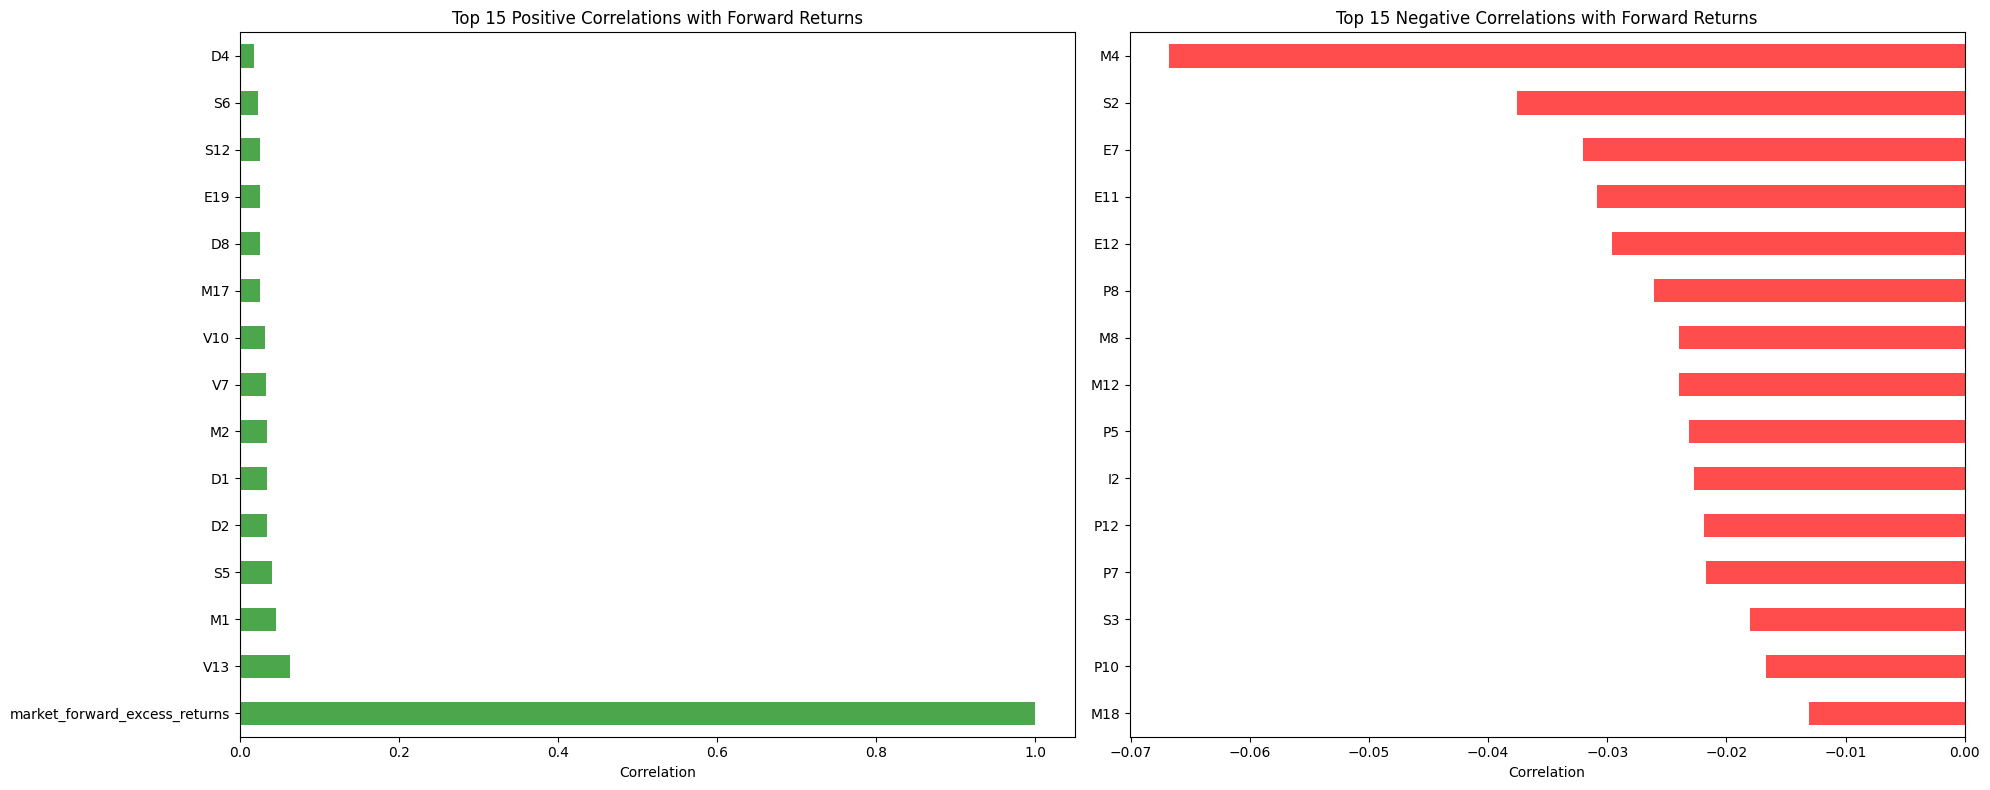


🔍 Market_Dynamics Internal Correlations:


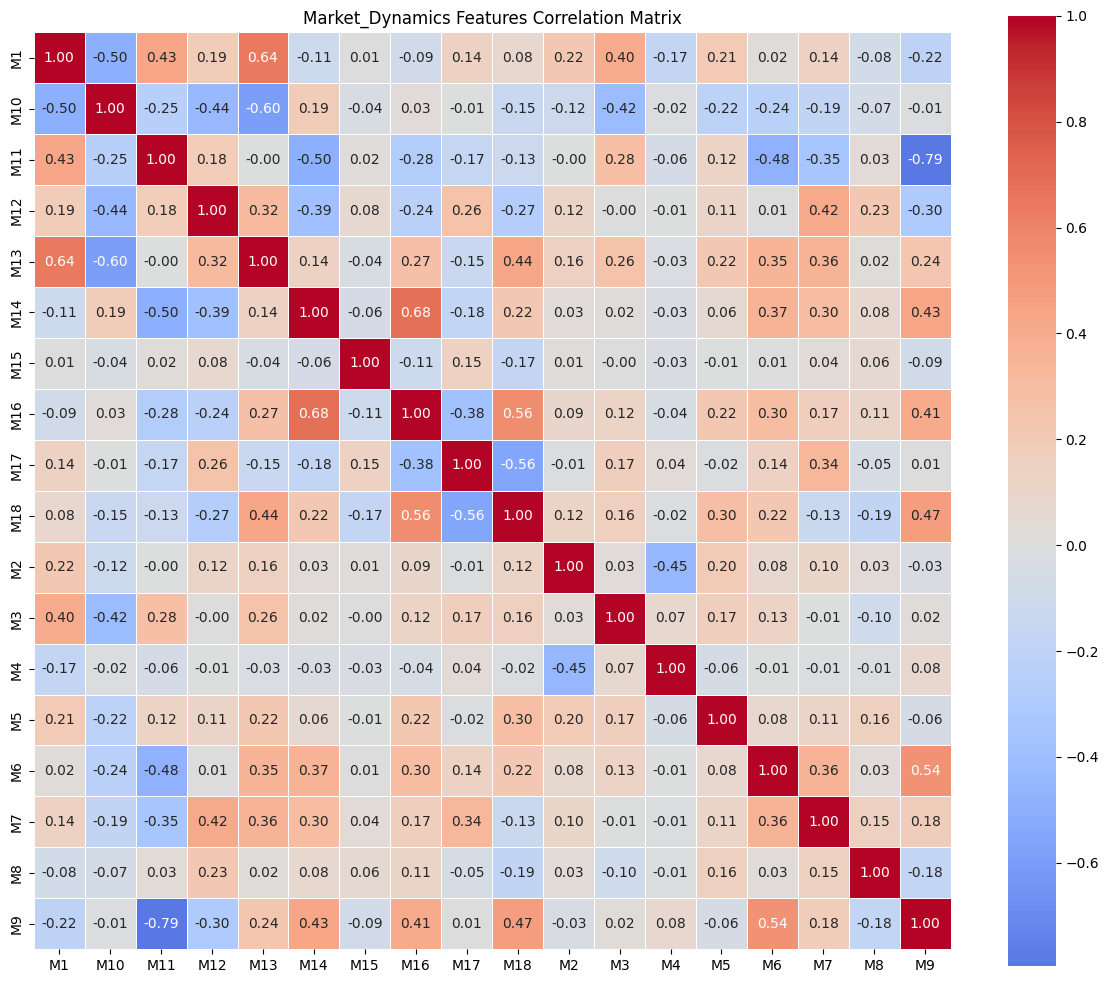


🔍 Macro_Economic Internal Correlations:
High correlations (|r| > 0.8): 5 pairs
  E15 - E9: 0.849
  E16 - E17: 0.929
  E16 - E18: 0.801
  E17 - E18: 0.886
  E2 - E3: 0.895


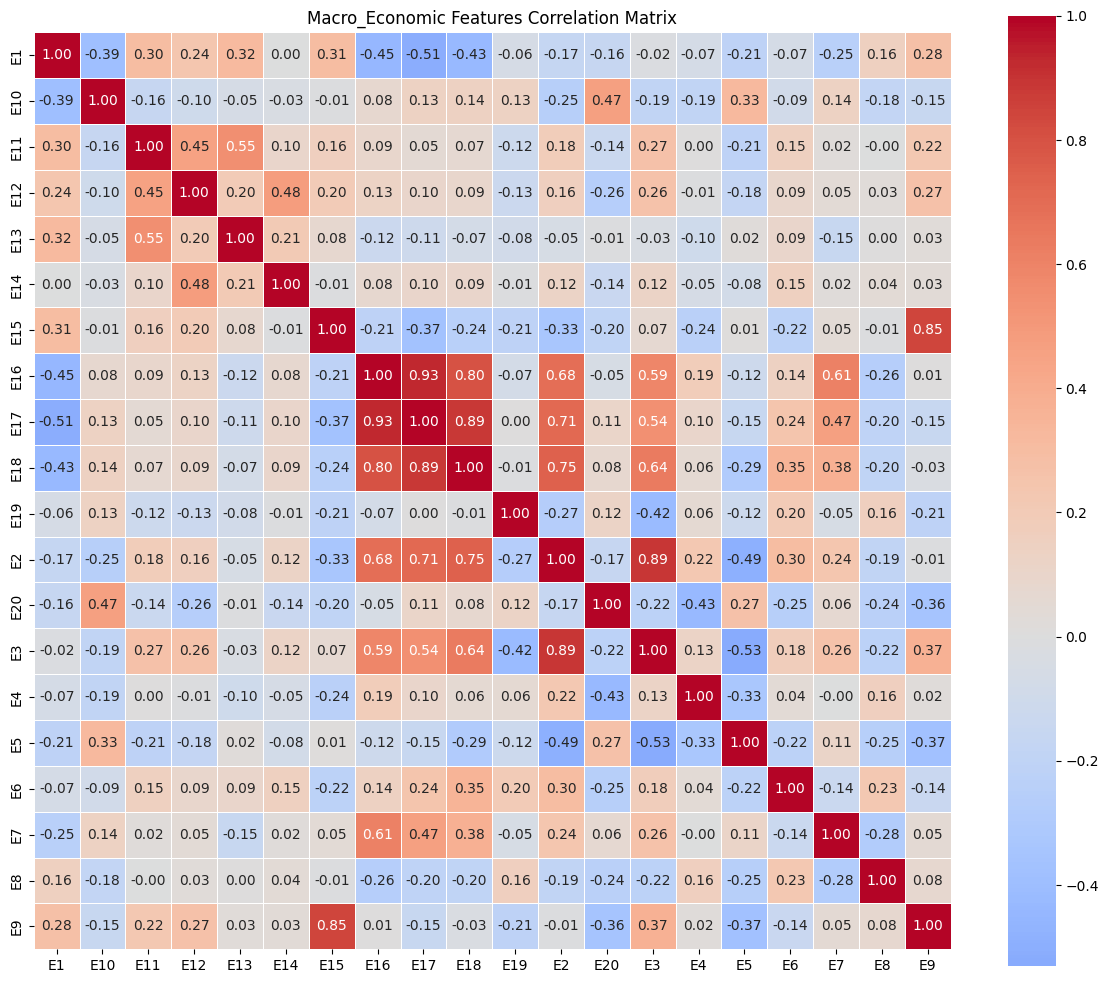


🔍 Interest_Rate Internal Correlations:
High correlations (|r| > 0.8): 2 pairs
  I4 - I8: 0.830
  I5 - I9: 1.000


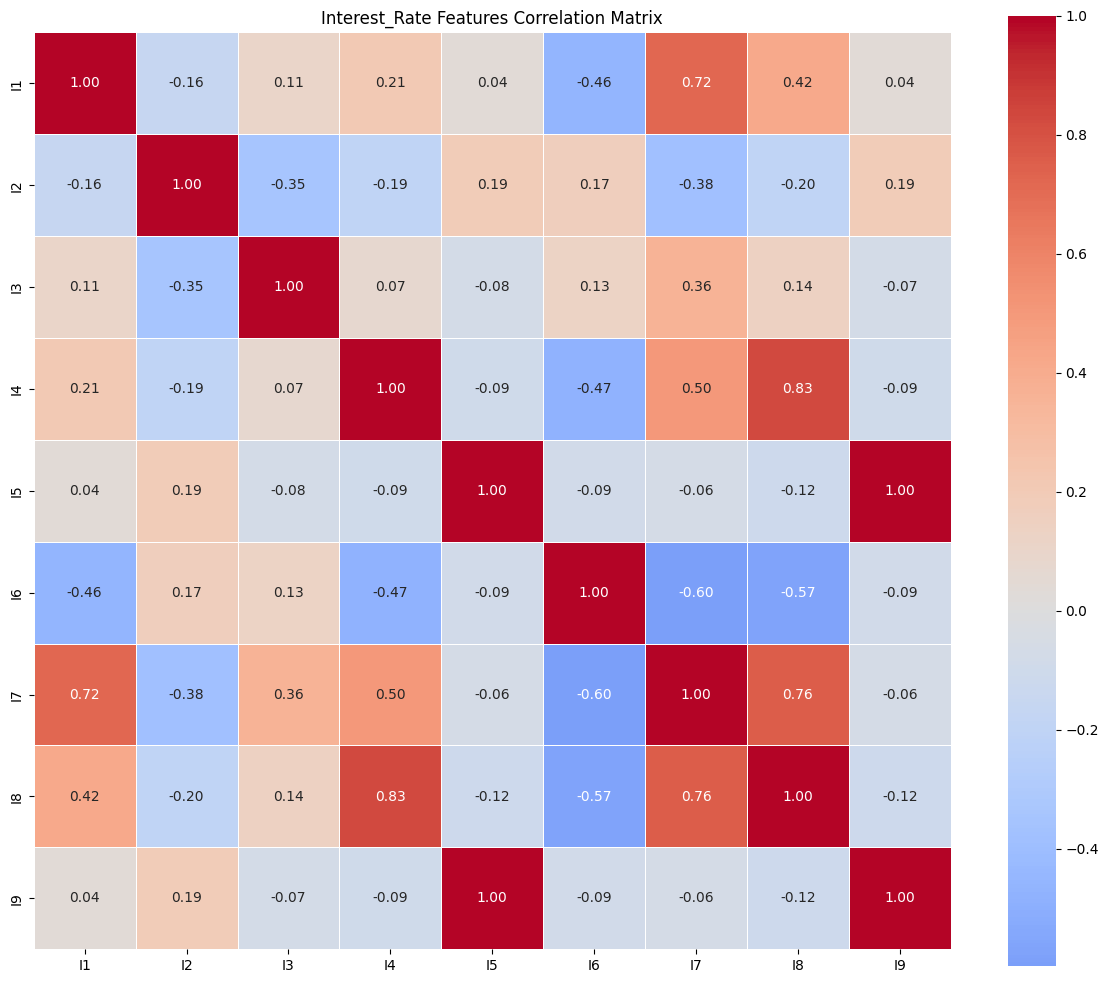


🔍 Price_Valuation Internal Correlations:
High correlations (|r| > 0.8): 2 pairs
  P10 - P11: 0.938
  P10 - P8: 0.807


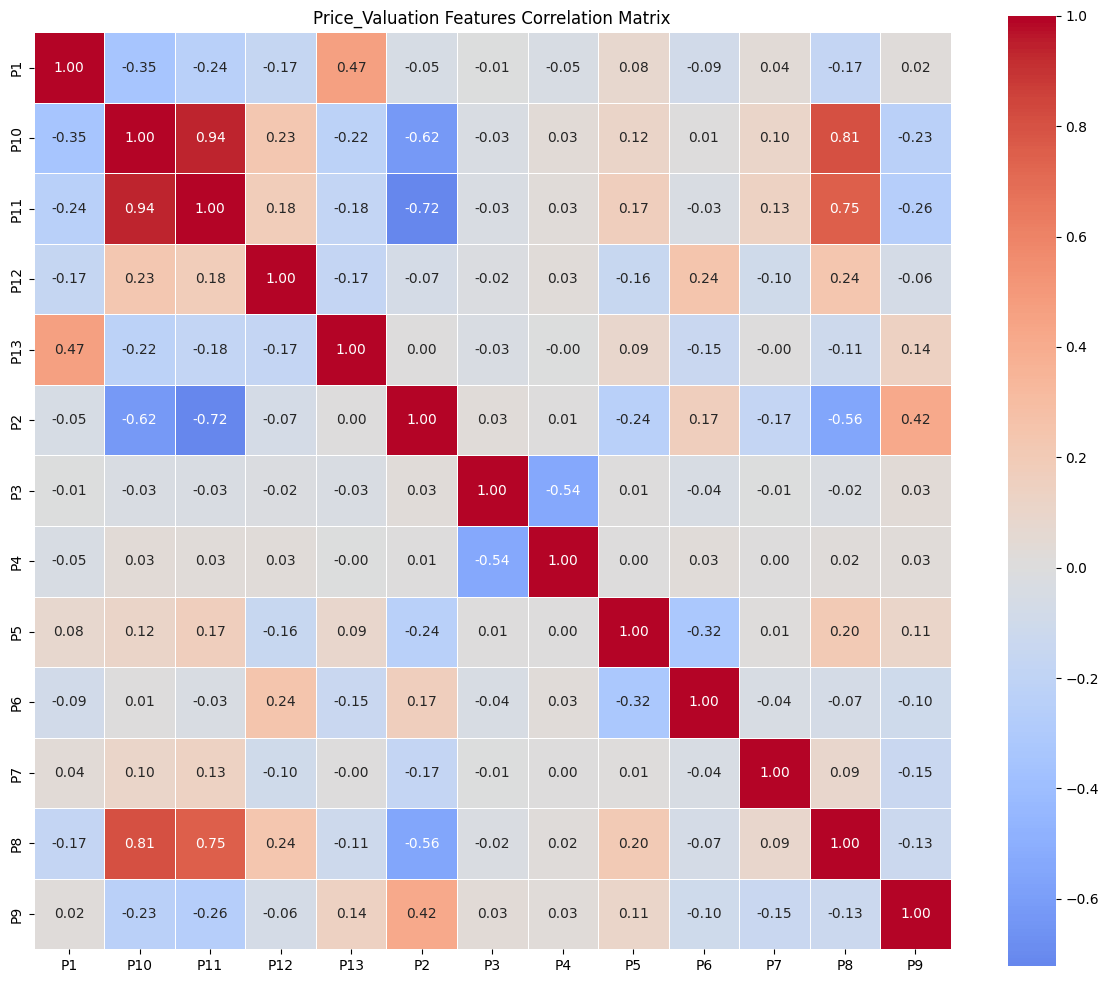


🔍 Volatility Internal Correlations:
High correlations (|r| > 0.8): 9 pairs
  V1 - V11: 0.877
  V1 - V2: 0.843
  V1 - V3: 0.802
  V1 - V4: 0.817
  V1 - V8: 0.872
  V10 - V7: 0.934
  V10 - V9: 0.985
  V2 - V4: 0.933
  V7 - V9: 0.977


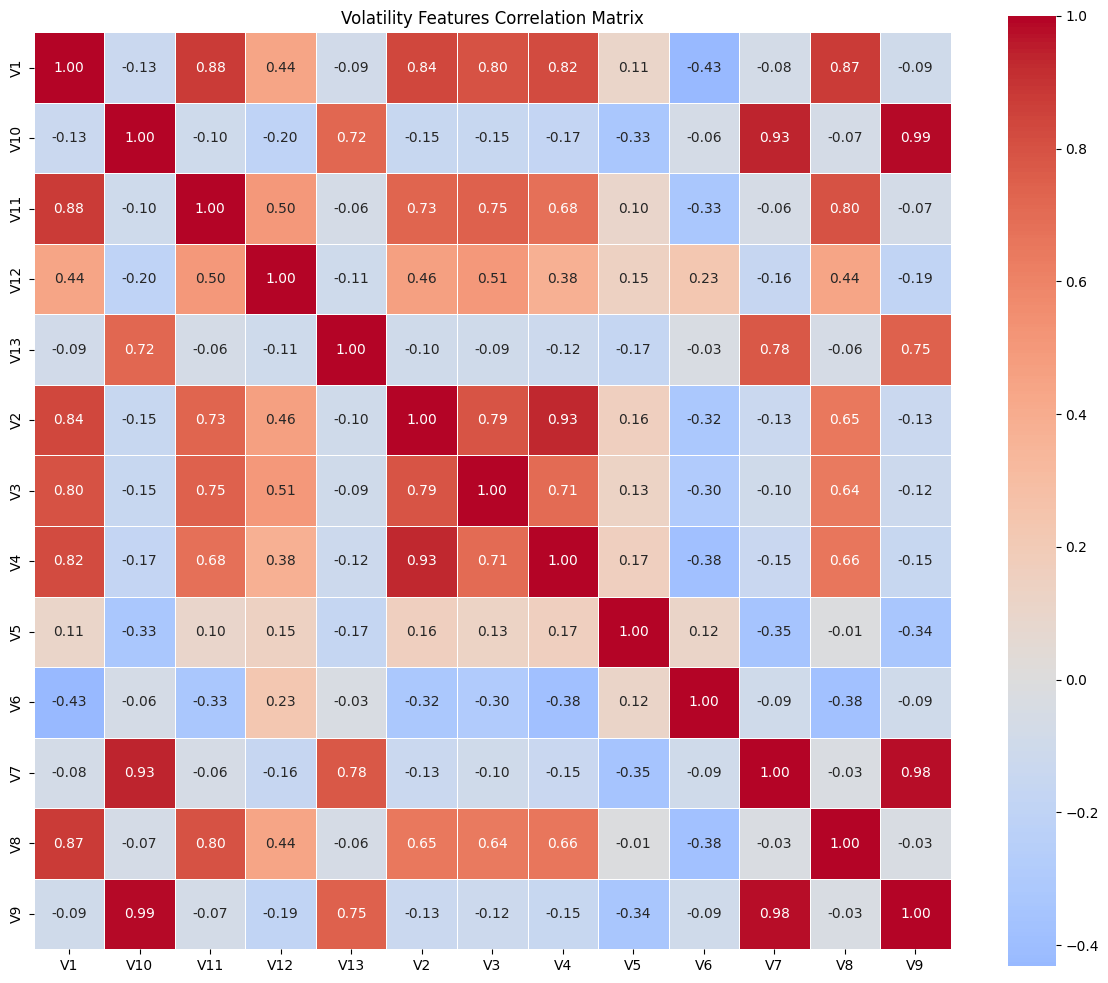


🔍 Sentiment Internal Correlations:
High correlations (|r| > 0.8): 3 pairs
  S10 - S11: 0.916
  S10 - S4: 0.820
  S11 - S4: 0.901


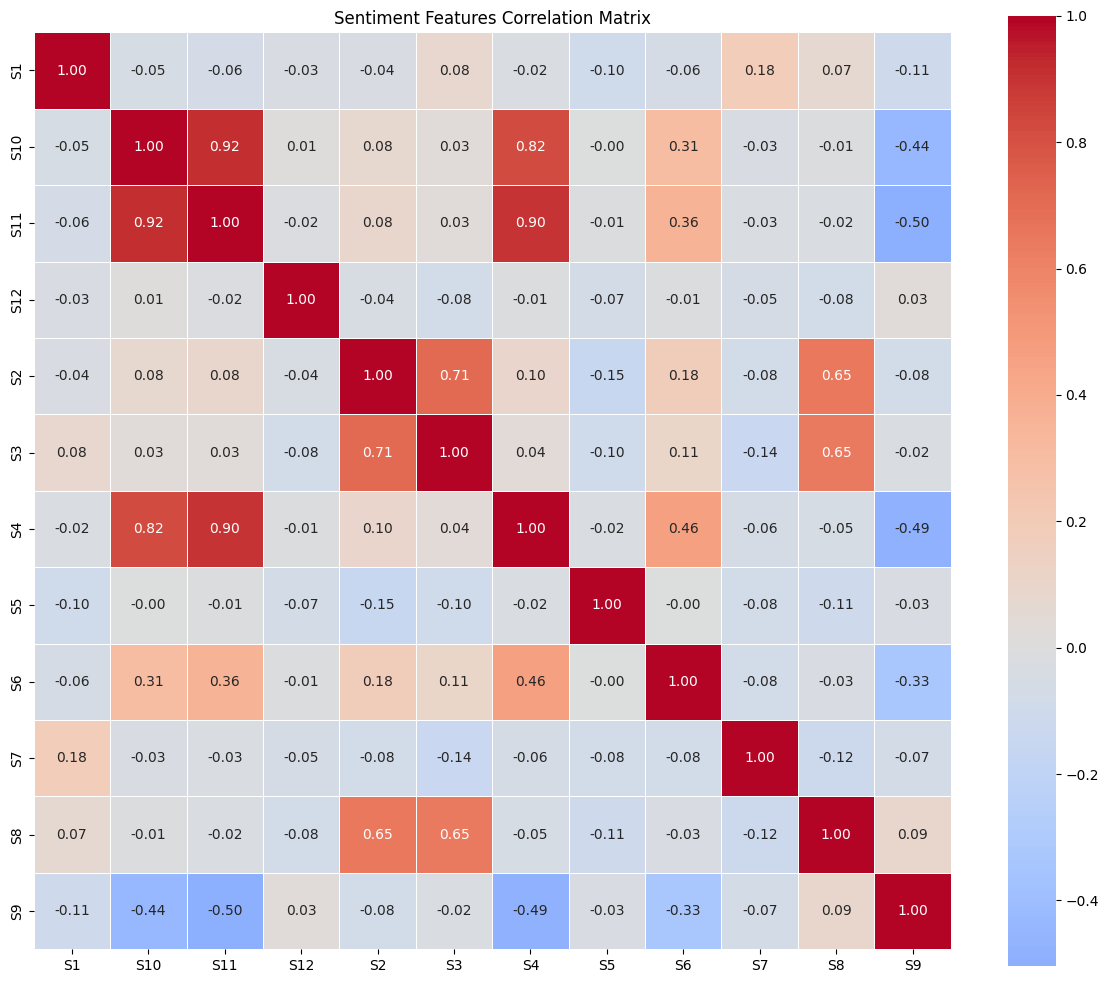


🔍 Dummy_Binary Internal Correlations:
High correlations (|r| > 0.8): 1 pairs
  D1 - D2: 1.000


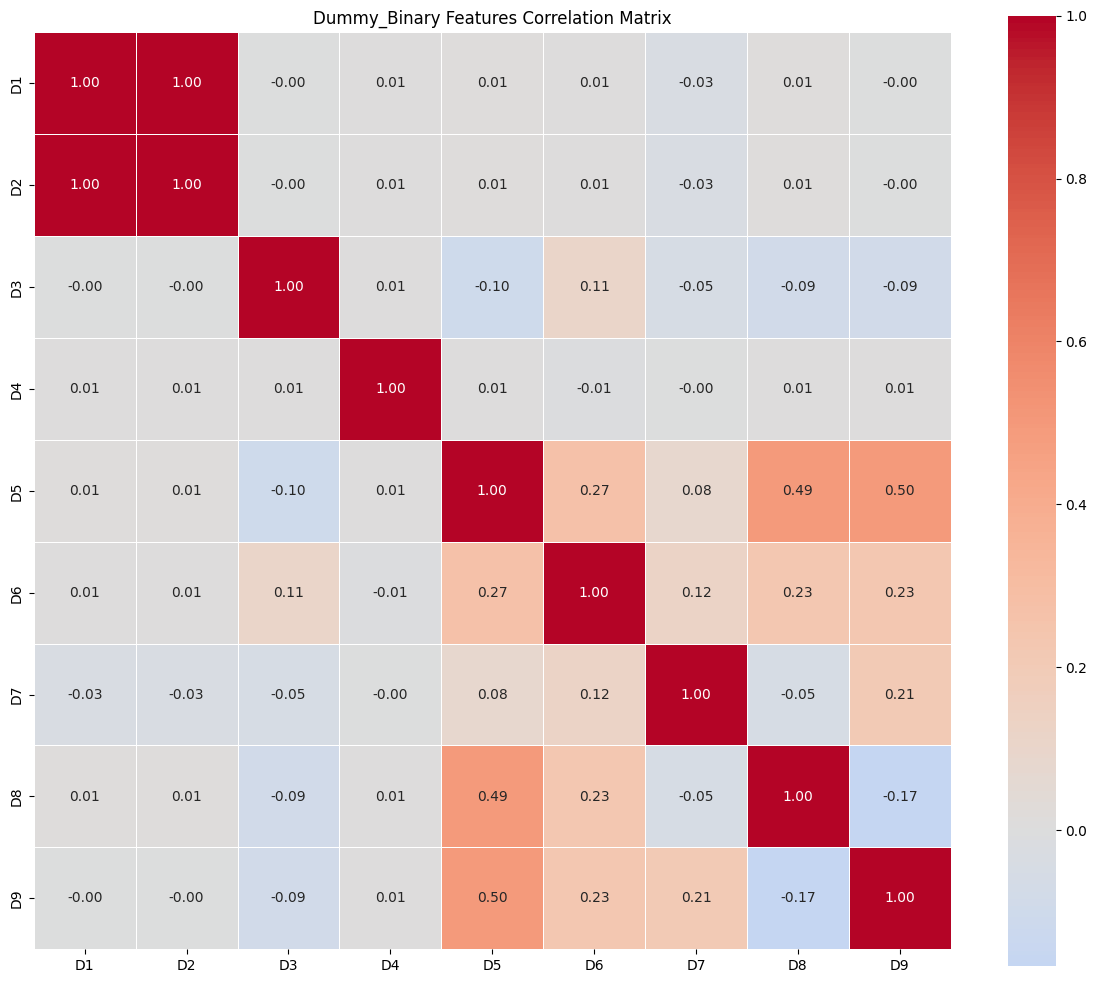

In [15]:
analyze_correlations(train, feature_categories)

# Time-Series Analysis

In [16]:
def analyze_time_series_patterns(df, feature_categories):
    if 'date_id' not in df.columns:
        print("❌ No date_id column found for time series analysis")
        return
    df_sorted = df.sort_values('date_id')
    if 'forward_returns' in df.columns:
        returns = df_sorted['forward_returns'].dropna()
        print("📊 TIME SERIES STATISTICS:")
        print(f"Total trading days: {len(returns)}")
        print(f"Date range: {df_sorted['date_id'].min()} to {df_sorted['date_id'].max()}")
        returns_series = pd.Series(returns.values, index=df_sorted.loc[returns.index, 'date_id'])
        window_sizes = [30, 90, 252]
        fig, axes = plt.subplots(2,2, figsize=(20,12))

        axes[0, 0].plot(returns_series.index, returns_series.values, alpha=0.7)
        axes[0, 0].set_title('Forward Returns Over Time')
        axes[0, 0].set_xlabel('Date ID')
        axes[0, 0].set_ylabel('Returns')
        axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

        rolling_vol = returns_series.rolling(30).std()
        axes[0, 1].plot(rolling_vol.index, rolling_vol.values, color='orange')
        axes[0, 1].set_title('30-Day Rolling Volatility')
        axes[0, 1].set_xlabel('Date ID')
        axes[0, 1].set_ylabel('Volatility')

        #cumulative returns --->>
        cumulative_returns = (1+ returns_series).cumprod()
        axes[1, 0].plot(cumulative_returns.index, cumulative_returns.values, color='green')
        axes[1, 0].set_title('Cumulative Returns')
        axes[1, 0].set_xlabel('Date ID')
        axes[1, 0].set_ylabel('Cumulative Return')

        # Distribution by year/period
        # Assuming date_id represents days since a reference point
        # We'll create bins for different time periods
        date_bins = pd.cut(df_sorted['date_id'], bins=10)
        period_returns = df_sorted.groupby(date_bins)['forward_returns'].agg(['mean', 'std', 'count']).dropna()
        axes[1, 1].bar(range(len(period_returns)), period_returns['mean'], yerr=period_returns['std'], alpha=0.7, capsize=5)
        axes[1, 1].set_title('Average Returns by Time Period')
        axes[1, 1].set_xlabel('Time Period')
        axes[1, 1].set_ylabel('Average Return')
        axes[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

        if len(returns) > 252*2:
            print("\n🗓️ SEASONALITY ANALYSIS:")
            
            # Create day of week and month proxies (simplified)
            # This is a simplified approach - in real scenarios you'd have actual dates
            df_sorted['day_proxy'] = df_sorted['date_id'] % 7
            df_sorted['month_proxy'] = (df_sorted['date_id'] // 30) % 12
            
            seasonality_stats = df_sorted.groupby('day_proxy')['forward_returns'].agg(['mean', 'std', 'count']).dropna()
            
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))

            # Day of week effect
            axes[0].bar(seasonality_stats.index, seasonality_stats['mean'], alpha=0.7)
            axes[0].set_title('Average Returns by Day of Week Proxy')
            axes[0].set_xlabel('Day Proxy')
            axes[0].set_ylabel('Average Return')
            
            # Month effect
            monthly_stats = df_sorted.groupby('month_proxy')['forward_returns'].agg(['mean', 'std']).dropna()
            axes[1].bar(monthly_stats.index, monthly_stats['mean'], alpha=0.7)
            axes[1].set_title('Average Returns by Month Proxy')
            axes[1].set_xlabel('Month Proxy')
            axes[1].set_ylabel('Average Return')
            
            plt.tight_layout()
            plt.show()


📊 TIME SERIES STATISTICS:
Total trading days: 9021
Date range: 0 to 9020


/var/folders/yn/q_cgy5m947g4bj3shsg12lpc0000gn/T/ipykernel_7151/1106551008.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  period_returns = df_sorted.groupby(date_bins)['forward_returns'].agg(['mean', 'std', 'count']).dropna()


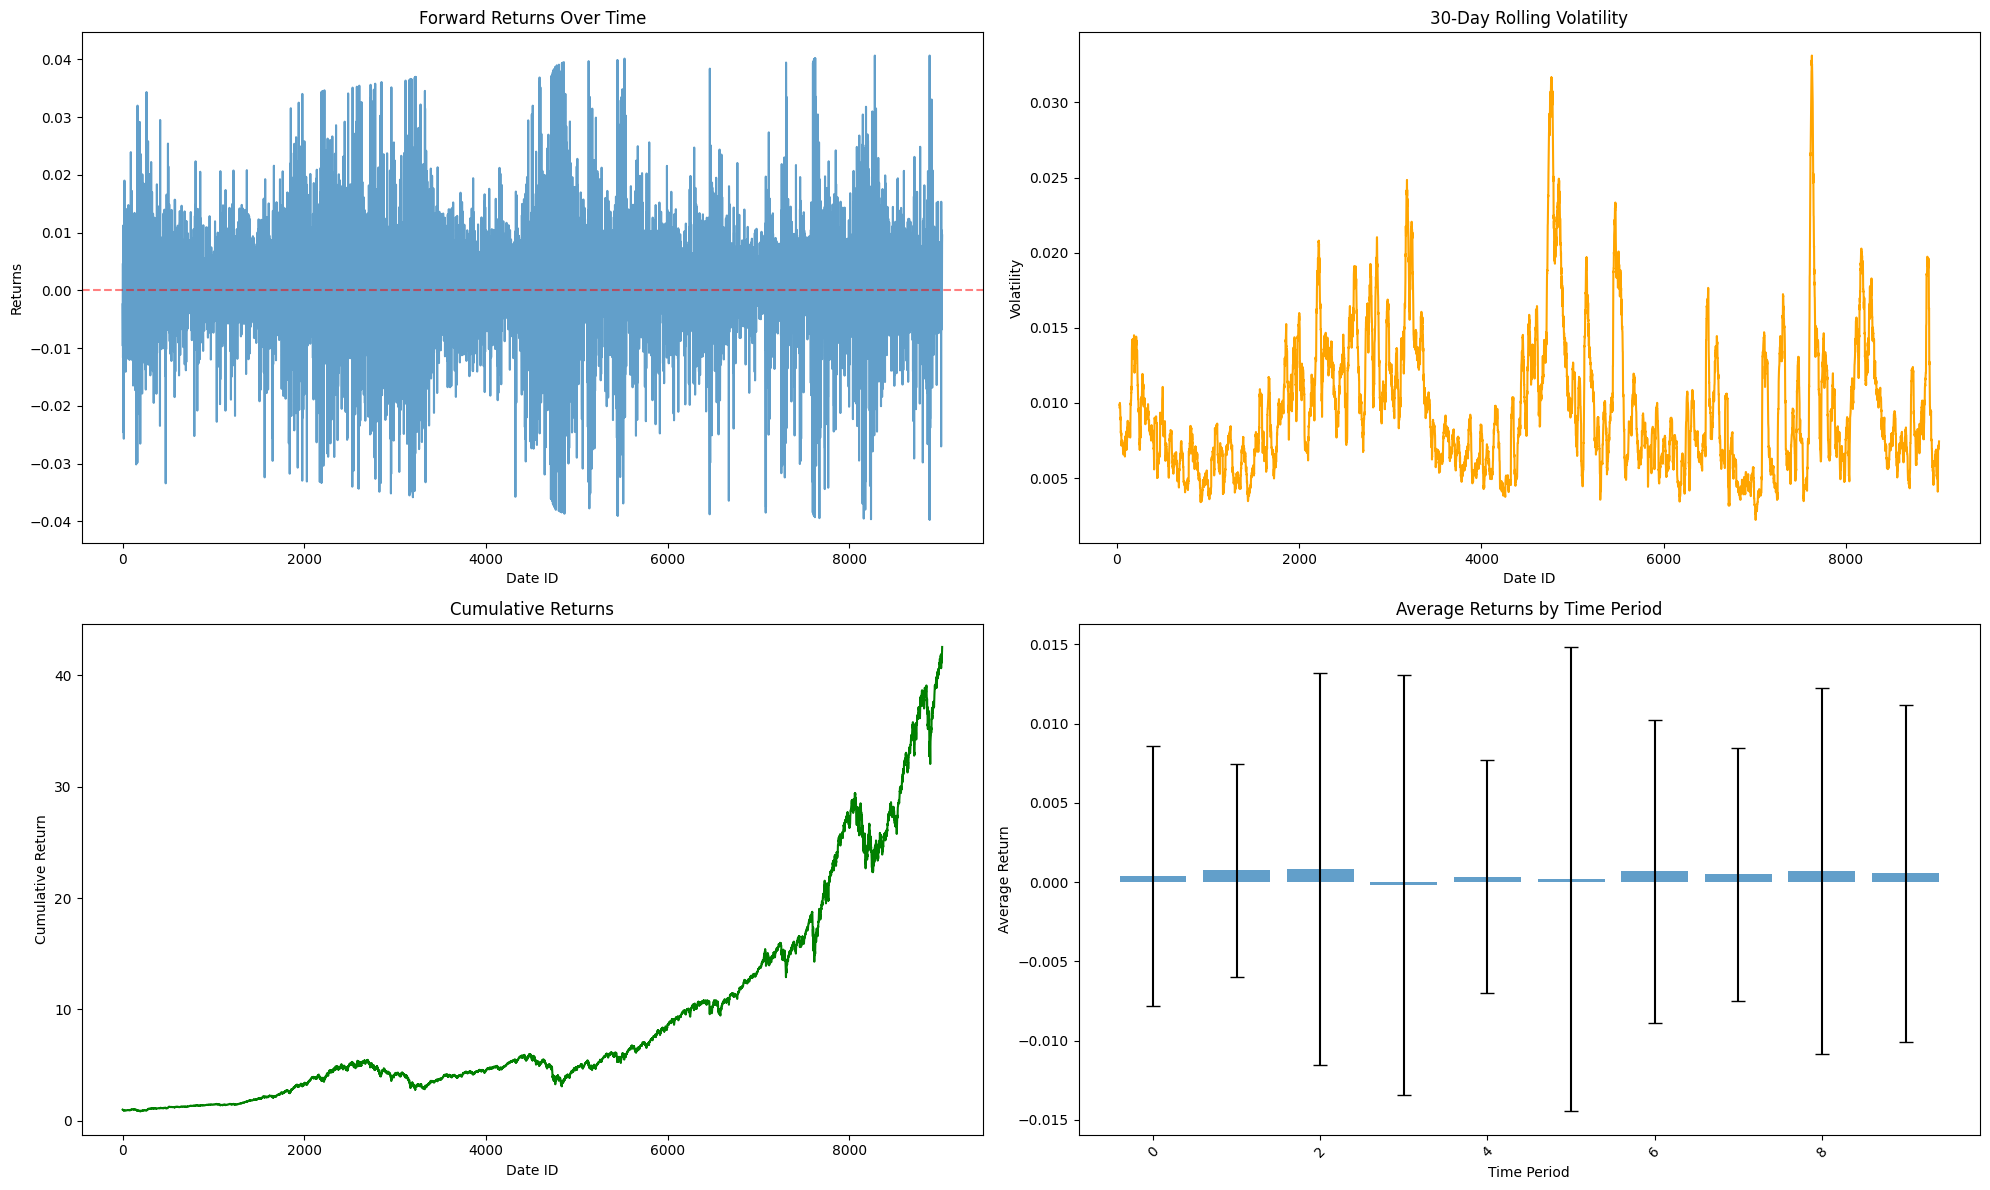


🗓️ SEASONALITY ANALYSIS:


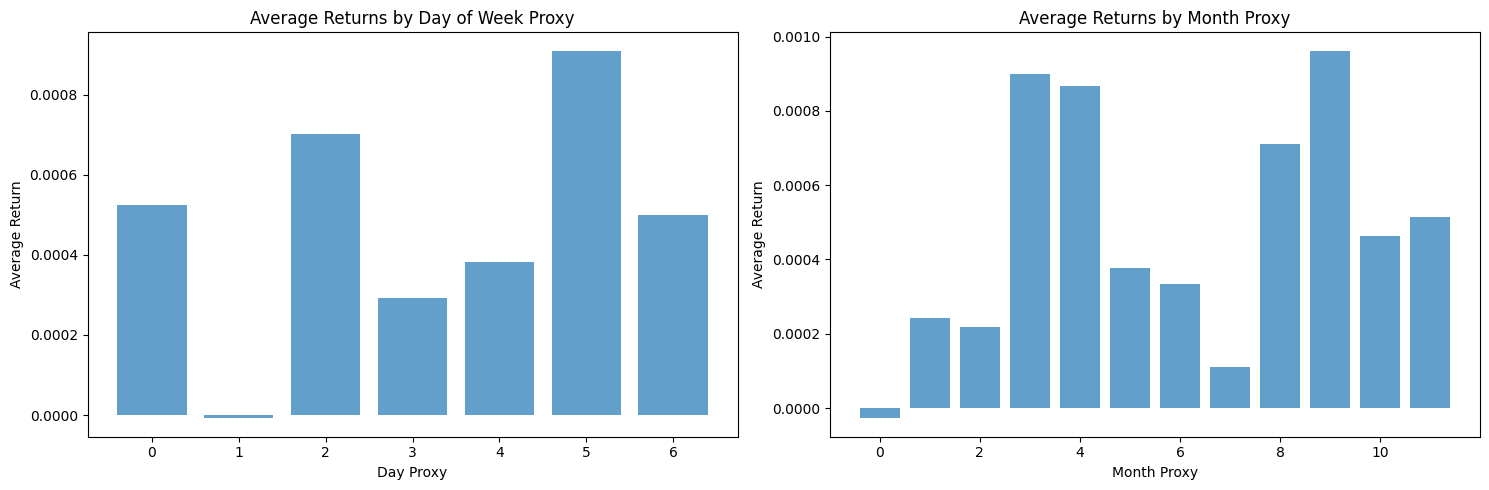

In [17]:
analyze_time_series_patterns(train, feature_categories)

# Feature Importance and Selection

In [18]:
def analyze_feature_importance(df, feature_categories, max_features=50):
    print("\n FEATURE IMPORTANCE ANALYSIS")
    print("="*50)
    
    if 'forward_returns' not in df.columns:
        print("❌ No target variable found for feature importance analysis")
        return
    
    feature_cols = []
    for category, features in feature_categories.items():
        if category!= 'Special':
            feature_cols.extend(features)
    
    if len(feature_cols) > max_features:
        feature_cols = feature_cols[:max_features]
        print(f"⚠️ Limited to first {max_features} features for computational efficiency")
    
    # Create feature matrix
    X = df[feature_cols].fillna(0)
    y = df['forward_returns'].fillna(0)
    
    # Remove rows where target is missing
    mask = ~df['forward_returns'].isna()
    X = X[mask]
    y = y[mask]
    
    if len(X) == 0:
        print("❌ No valid data for feature importance analysis")
        return
    
    print(f"📊 Analyzing {len(feature_cols)} features with {len(X)} samples")
    
    corr_importance = abs(X.corrwith(y)).sort_values(ascending=False)
    
    # 2. Mutual Information
    try:
        mi_scores = mutual_info_regression(X, y, random_state=42)
        mi_importance = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=False)
    except:
        print("⚠️ Mutual information calculation failed")
        mi_importance = pd.Series(index=feature_cols)

    #Combine Results
    importance_df = pd.DataFrame({
        'Correlation' : corr_importance,
        'Mutual_Info' : mi_importance
    }).fillna(0)

    importance_df['Composite_Score']=(
        importance_df['Correlation'].rank(pct=True) +
        importance_df['Mutual_Info'].rank(pct=True)
    ) / 2
    importance_df = importance_df.sort_values('Composite_Score', ascending=False)
    print("\n🏆 TOP 20 MOST IMPORTANT FEATURES:")
    display(importance_df.head(20))

    # Visualize feature importance
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Correlation importance
    top_corr = importance_df.head(15)['Correlation']
    top_corr.plot(kind='barh', ax=axes[0], color='blue', alpha=0.7)
    axes[0].set_title('Top 15 Features by Correlation')
    axes[0].set_xlabel('Absolute Correlation')
    
    # Mutual information importance
    top_mi = importance_df.head(15)['Mutual_Info']
    top_mi.plot(kind='barh', ax=axes[1], color='green', alpha=0.7)
    axes[1].set_title('Top 15 Features by Mutual Information')
    axes[1].set_xlabel('Mutual Information Score')
    
    # Composite score
    top_composite = importance_df.head(15)['Composite_Score']
    top_composite.plot(kind='barh', ax=axes[2], color='red', alpha=0.7)
    axes[2].set_title('Top 15 Features by Composite Score')
    axes[2].set_xlabel('Composite Score')
    
    plt.tight_layout()
    plt.show()
    
    return importance_df



 FEATURE IMPORTANCE ANALYSIS
⚠️ Limited to first 50 features for computational efficiency
📊 Analyzing 50 features with 9021 samples

🏆 TOP 20 MOST IMPORTANT FEATURES:


,Correlation,Mutual_Info,Composite_Score
E19,0.024086,0.106183,0.96
M17,0.023138,0.047183,0.80
E11,0.029121,0.043106,0.79
E18,0.007977,0.060025,0.79
E12,0.028021,0.041329,0.77
M18,0.009890,0.056414,0.75
I2,0.022075,0.043328,0.74
M4,0.064640,0.036025,0.71
I9,0.006725,0.057669,0.71
E6,0.015159,0.044004,0.71


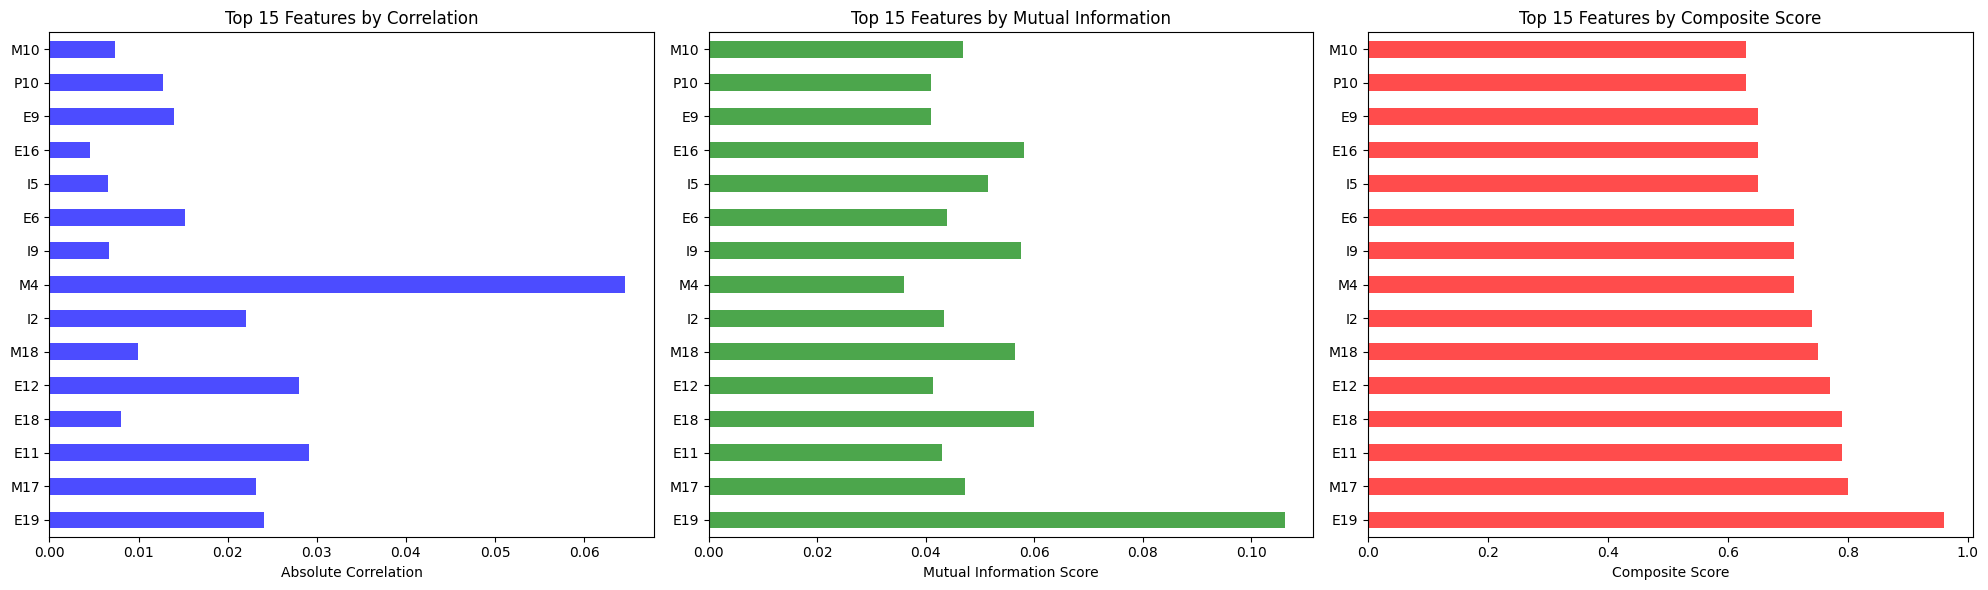

In [19]:
importance_results = analyze_feature_importance(train, feature_categories)

# Dimensionality Analysis

In [20]:
def analyze_dimensionality(df, feature_categories, n_components=50):
    """Analyze dimensionality and perform PCA"""
    
    print("\n📐 DIMENSIONALITY ANALYSIS")
    print("="*50)
    
    # Prepare feature matrix
    feature_cols = []
    for category, features in feature_categories.items():
        if category != 'Special':
            feature_cols.extend(features)
    
    X = df[feature_cols].fillna(0)
    
    print(f"📊 Original dimensions: {X.shape}")
    print(f"📊 Memory usage: {X.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    n_components = min(n_components, X.shape[1], X.shape[0])
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"📊 Reduced dimensions: {X_pca.shape}")

    # Analyze explained variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    print(f"\n📈 VARIANCE EXPLAINED:")
    print(f"First component: {explained_variance_ratio[0]:.4f}")
    print(f"First 5 components: {cumulative_variance[4]:.4f}")
    print(f"First 10 components: {cumulative_variance[9]:.4f}")
    print(f"First 20 components: {cumulative_variance[19] if len(cumulative_variance) > 19 else cumulative_variance[-1]:.4f}")
    
    # Visualize explained variance
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Individual explained variance
    axes[0].bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    axes[0].set_title('Explained Variance by Component')
    axes[0].set_xlabel('Principal Component')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[0].set_xlim(0, min(20, len(explained_variance_ratio)))

    # Cumulative explained variance
    axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
    axes[1].axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% Variance')
    axes[1].axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% Variance')
    axes[1].axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='95% Variance')
    axes[1].set_title('Cumulative Explained Variance')
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('Cumulative Explained Variance')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Find number of components needed for different variance thresholds
    thresholds = [0.8, 0.9, 0.95, 0.99]
    for threshold in thresholds:
        n_needed = np.argmax(cumulative_variance >= threshold) + 1
        if cumulative_variance[n_needed-1] >= threshold:
            print(f"📊 Components needed for {threshold*100}% variance: {n_needed}")
    
    return pca, X_pca


📐 DIMENSIONALITY ANALYSIS
📊 Original dimensions: (9021, 94)
📊 Memory usage: 6.47 MB
📊 Reduced dimensions: (9021, 50)

📈 VARIANCE EXPLAINED:
First component: 0.1254
First 5 components: 0.4138
First 10 components: 0.5788
First 20 components: 0.7501


/Users/harshitagarwal/Desktop/Kaggle Competitions/denv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/harshitagarwal/Desktop/Kaggle Competitions/denv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/harshitagarwal/Desktop/Kaggle Competitions/denv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/harshitagarwal/Desktop/Kaggle Competitions/denv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/harshitagarwal/Desktop/Kaggle Competitions/denv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/harshitagarwal/Desktop/Ka

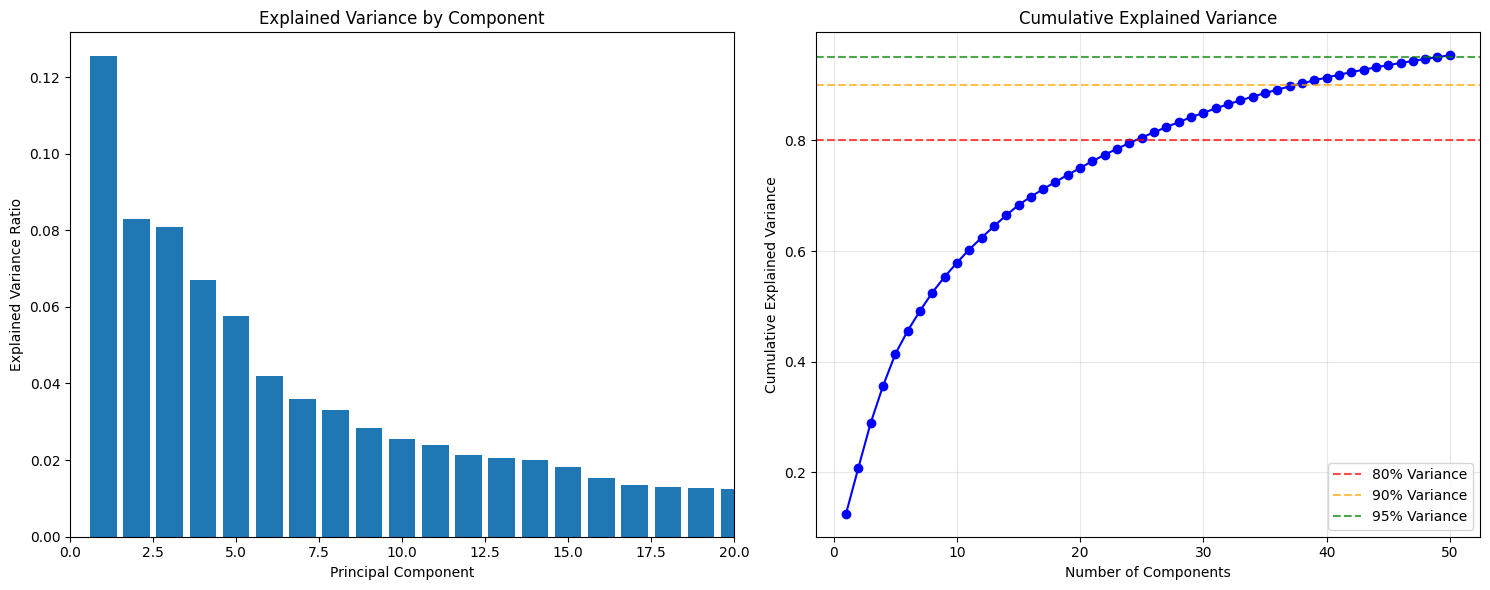

📊 Components needed for 80.0% variance: 25
📊 Components needed for 90.0% variance: 38
📊 Components needed for 95.0% variance: 49


In [21]:
pca_results, pca_data = analyze_dimensionality(train, feature_categories)

# Outlier Detection and Analysis

In [22]:
def analyze_outliers(df, feature_categories, method='iqr'):
    """Comprehensive outlier analysis"""
    
    print("\n🚨 OUTLIER ANALYSIS")
    print("="*50)
    
    outlier_summary = {}
    
    # Analyze target variable outliers
    if 'forward_returns' in df.columns:
        target_data = df['forward_returns'].dropna()
        
        if method == 'iqr':
            Q1 = target_data.quantile(0.25)
            Q3 = target_data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            target_outliers = target_data[(target_data < lower_bound) | (target_data > upper_bound)]
        else:  # z-score method
            z_scores = np.abs(stats.zscore(target_data))
            target_outliers = target_data[z_scores > 3]

        print(f"📊 TARGET VARIABLE OUTLIERS:")
        print(f"Total outliers: {len(target_outliers)} ({len(target_outliers)/len(target_data)*100:.2f}%)")
        print(f"Outlier range: [{target_outliers.min():.6f}, {target_outliers.max():.6f}]")
        
        outlier_summary['forward_returns'] = len(target_outliers)
        
        # Visualize target outliers
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Box plot
        axes[0].boxplot(target_data, vert=True)
        axes[0].set_title('Forward Returns Box Plot')
        axes[0].set_ylabel('Forward Returns')
        
        # Histogram with outliers highlighted
        axes[1].hist(target_data, bins=50, alpha=0.7, label='Normal')
        axes[1].hist(target_outliers, bins=20, alpha=0.8, color='red', label='Outliers')
        axes[1].set_title('Forward Returns Distribution')
        axes[1].set_xlabel('Forward Returns')
        axes[1].legend()

        # Time series with outliers highlighted
        if 'date_id' in df.columns:
            target_with_date = df[['date_id', 'forward_returns']].dropna()
            outlier_dates = target_with_date[target_with_date['forward_returns'].isin(target_outliers)]
            
            axes[2].plot(target_with_date['date_id'], target_with_date['forward_returns'], 
                        alpha=0.7, label='Normal', linewidth=0.5)
            axes[2].scatter(outlier_dates['date_id'], outlier_dates['forward_returns'], 
                          color='red', alpha=0.8, s=20, label='Outliers')
            axes[2].set_title('Forward Returns Over Time with Outliers')
            axes[2].set_xlabel('Date ID')
            axes[2].legend()
        
        plt.tight_layout()
        plt.show()

    # Analyze feature outliers by category
    for category, features in feature_categories.items():
        if category == 'Special' or len(features) == 0:
            continue
            
        category_outliers = 0
        sample_features = features[:min(5, len(features))]  # Sample for efficiency
        
        for feature in sample_features:
            feature_data = df[feature].dropna()
            if len(feature_data) > 0:
                if method == 'iqr':
                    Q1 = feature_data.quantile(0.25)
                    Q3 = feature_data.quantile(0.75)
                    IQR = Q3 - Q1
                    if IQR > 0:
                        lower_bound = Q1 - 1.5 * IQR
                        upper_bound = Q3 + 1.5 * IQR
                        outliers = feature_data[(feature_data < lower_bound) | (feature_data > upper_bound)]
                        category_outliers += len(outliers)
                
        outlier_summary[category] = category_outliers
        print(f"📊 {category} outliers (sample): {category_outliers}")
    
    return outlier_summary



🚨 OUTLIER ANALYSIS
📊 TARGET VARIABLE OUTLIERS:
Total outliers: 600 (6.65%)
Outlier range: [-0.039754, 0.040661]


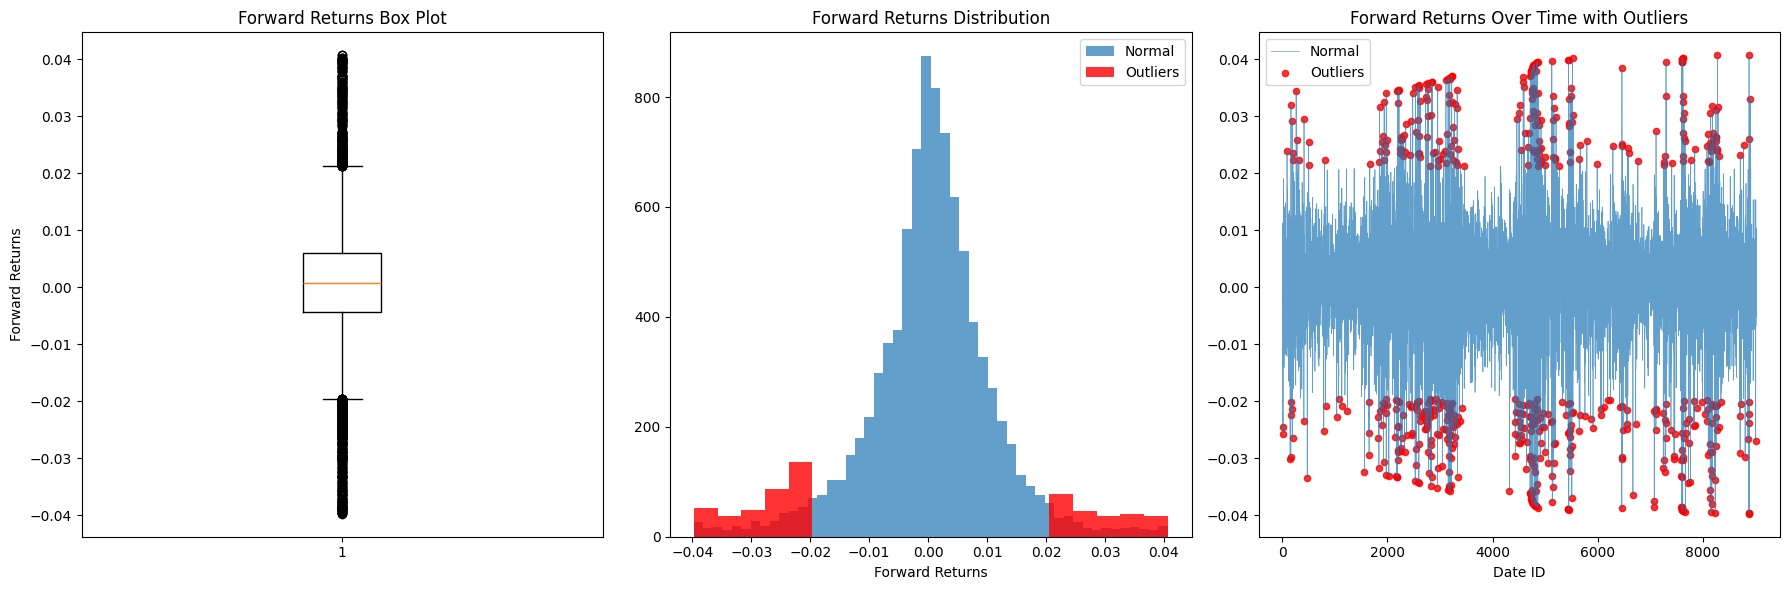

📊 Market_Dynamics outliers (sample): 252
📊 Macro_Economic outliers (sample): 3362
📊 Interest_Rate outliers (sample): 118
📊 Price_Valuation outliers (sample): 1031
📊 Volatility outliers (sample): 524
📊 Sentiment outliers (sample): 287
📊 Dummy_Binary outliers (sample): 0


In [23]:
outlier_results = analyze_outliers(train, feature_categories)

# Advanced Statistical Analysis

# Feature Stability Analysis